# Prevendo o LTV de clientes do Varejo

O LTV - “lifetime value” ou “valor vitalício” é uma métrica estatística que estima o lucro líquido da vida de um cliente dentro da empresa. É comum termos clientes mais valiosos que outros, estes se dão pela frequência  que compram ou pela grande receita que geram, e é importante investirmos mais naqueles que geram um maior valor para a empresa.


Este projeto tem como objetivo identificar padrões de comportamento dos clientes do Varejo a fim de prever o LTV do cliente para a empresa. Mais especificamente, foi dado um dataset referênte à 01/2020 até 02/2021 e devemos prever o LTV de cada cliente do dia 25/02/2021 até 24/05/2021. 

### O Dataset
Foi disponibilizado um Dataset que contém as seguintes informações:

- ID_VENDA - Id único para cada registro
- DT_VENDA - Data da venda
- LOJA - Id único da loja em que a venda foi realizada
- QTD_SKU - Quantidade de produtos vendidos
- VALOR - Valor total da venda
- ID_CLIENTE - Id único do cliente
- CANAL - Canal de venda (FIS - Físico, ECM - E-commerce, TELEVENDAS - Telefone, WHATSAPP - WhatsApp, IFOOD - iFood)

O dataset é nomeado por `sales_20_21_train.csv` e foi obtido em 01/10/2021 disponibilizado pela equipe do VLabs para o desafio de previsão do LTV. 

1. [Configurações iniciais](#section-zero)

2. [Obtenção e visualização dos dados](#section-one)

3. [Pré-processamento dos dados](#section-two)

4. [Analise dos dados](#section-three)
    
    4.1. [Quantidade de vendas realizadas por cada loja](#section-three-one)
    
    4.2. [Receita total gerada por cada loja](#section-three-two)
    
    4.3. [Canais de vendas mais recorrentes](#section-three-three)
    
    4.4. [Quantidade de vendas por dia](#section-three-four)
    
    4.5. [Receita total por dia](#section-three-five)
    
    4.6. [Correlação entre as variáveis](#section-three-six)

5. [Segmentando os dados](#section-four)

    5.1.1. [Cálculo da Recência](#section-four-one-one)
    
    5.1.2. [Atribuindo um Score para a Recência](#section-four-one-two)
    
    5.2.1. [Cálculo da Frequência](#section-four-two-one)
    
    5.2.2. [Atribuindo um Score para a Frequência](#section-four-two-two)
    
    5.3.1. [Cálculo da Receita](#section-three-one)
    
    5.3.2. [Atribuindo um Score para a Receita](#section-four-three-two)

6. [Cálculo do RFM](#section-five)

7. [Cálculo do LTV](#section-six)

8. [Determinando features](#section-seven)

9. [Criação do modelo](#section-eight)



<a id="section-zero"></a>

# 1. Configurações iniciais

In [1]:
import pandas as pd

import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import preprocessing
from sklearn.cluster import KMeans

import numpy as np

import lightgbm as lgb

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [2]:
# Configurando o estilo dos plots
sns.set_style("whitegrid")

In [3]:
!pip install -U kaleido

     |████████████████████████████████| 79.9 MB 147 kB/s eta 0:00:01     |██████████▊                     | 26.8 MB 4.5 MB/s eta 0:00:12


<a id="section-one"></a>
# 2. Obtenção e visualização dos dados

In [4]:
# Obtendo os dados de treinamento
df = pd.read_csv('../input/VLabs-DC/sales_20_21_train.csv')

df.head()

,ID_VENDA,DT_VENDA,LOJA,QTD_SKU,VALOR,ID_CLIENTE,CANAL
0,1176550,2020-01-02,37,1,9.50,337763,FIS
1,11683461,2020-01-02,15,1,6.64,195687,FIS
2,3326484,2020-01-02,29,5,446.87,56059,FIS
3,7317475,2020-01-02,18,1,6.13,297533,FIS
4,4366938,2020-01-02,23,1,13.17,181284,FIS


In [5]:
# Verificando o shape
print("O dataset contém {} linhas e {} colunas.".format(*df.shape))

# Verificando duplicatas
print("E contém {} duplicatas.".format(df.duplicated().sum()))

O dataset contém 1630612 linhas e 7 colunas.
E contém 0 duplicatas.


In [6]:
# Verificando a porcentagem de valores faltantes dentro do Dataframe
percent_missing = df.isnull().sum() * 100 / len(df)

missing_value_df = pd.DataFrame({
                                 'PORCENTAGEM_VALORES_FALTANTES': percent_missing})

display(missing_value_df)

,PORCENTAGEM_VALORES_FALTANTES
ID_VENDA,0.0
DT_VENDA,0.0
LOJA,0.0
QTD_SKU,0.0
VALOR,0.0
ID_CLIENTE,0.0
CANAL,0.0


In [7]:
# Visualizando algumas variáveis estatísticas de cada feature contínua
df.describe()

,ID_VENDA,LOJA,QTD_SKU,VALOR,ID_CLIENTE
count,1.630612e+06,1.630612e+06,1.630612e+06,1.630612e+06,1.630612e+06
mean,5.914877e+06,2.165087e+01,5.018689e+00,8.074672e+01,1.966269e+05
std,3.608576e+06,1.287185e+01,4.208394e+00,1.085097e+02,1.154554e+05
min,4.000000e+00,0.000000e+00,1.000000e+00,2.000000e-02,0.000000e+00
25%,2.764558e+06,1.200000e+01,2.000000e+00,2.178000e+01,9.409200e+04
50%,5.682684e+06,2.100000e+01,4.000000e+00,4.753000e+01,1.976890e+05
75%,9.200227e+06,3.200000e+01,7.000000e+00,1.006300e+02,3.016960e+05
max,1.218562e+07,5.100000e+01,9.800000e+01,2.139047e+04,3.844200e+05


In [8]:
# Visualizando os valores únicos de cada feature
for col in df:
    print('A coluna {} possui {} valores únicos'.format(col, len(df[col].unique())))


A coluna ID_VENDA possui 1630612 valores únicos
A coluna DT_VENDA possui 406 valores únicos
A coluna LOJA possui 52 valores únicos
A coluna QTD_SKU possui 83 valores únicos
A coluna VALOR possui 38459 valores únicos
A coluna ID_CLIENTE possui 210269 valores únicos
A coluna CANAL possui 5 valores únicos


<a id="section-two"></a>
# 3. Pré-processamento dos dados

In [9]:
# Convertendo o tipo da coluna DT_VENDA de string para datetime.
df['DT_VENDA'] = pd.to_datetime(df['DT_VENDA'])

df.head()

,ID_VENDA,DT_VENDA,LOJA,QTD_SKU,VALOR,ID_CLIENTE,CANAL
0,1176550,2020-01-02,37,1,9.50,337763,FIS
1,11683461,2020-01-02,15,1,6.64,195687,FIS
2,3326484,2020-01-02,29,5,446.87,56059,FIS
3,7317475,2020-01-02,18,1,6.13,297533,FIS
4,4366938,2020-01-02,23,1,13.17,181284,FIS


In [10]:
# Visualizando os dados estatísticos das datas
df['DT_VENDA'].describe(datetime_is_numeric=True)

count                          1630612
mean     2020-08-11 16:16:30.065570048
min                2020-01-02 00:00:00
25%                2020-04-18 00:00:00
50%                2020-09-01 00:00:00
75%                2020-11-25 00:00:00
max                2021-02-24 00:00:00
Name: DT_VENDA, dtype: object

<a id="section-three"></a>
# 4. Analise dos dados

<a id="section-three-one"></a>

### 4.1. Visualizando a quantidade de vendas realizadas por cada loja

In [11]:
# Dataset para visualizar quantas vendas/receita foram geradas em cada loja durante todo o período do Dataset
store_sells = pd.DataFrame(df.groupby('LOJA').count()['ID_VENDA'])

store_sells.columns = ['QTD_TOTAL_VENDAS']

store_sells.head()

,QTD_TOTAL_VENDAS
LOJA,
0,41861
1,26060
2,45587
3,34991
4,57073


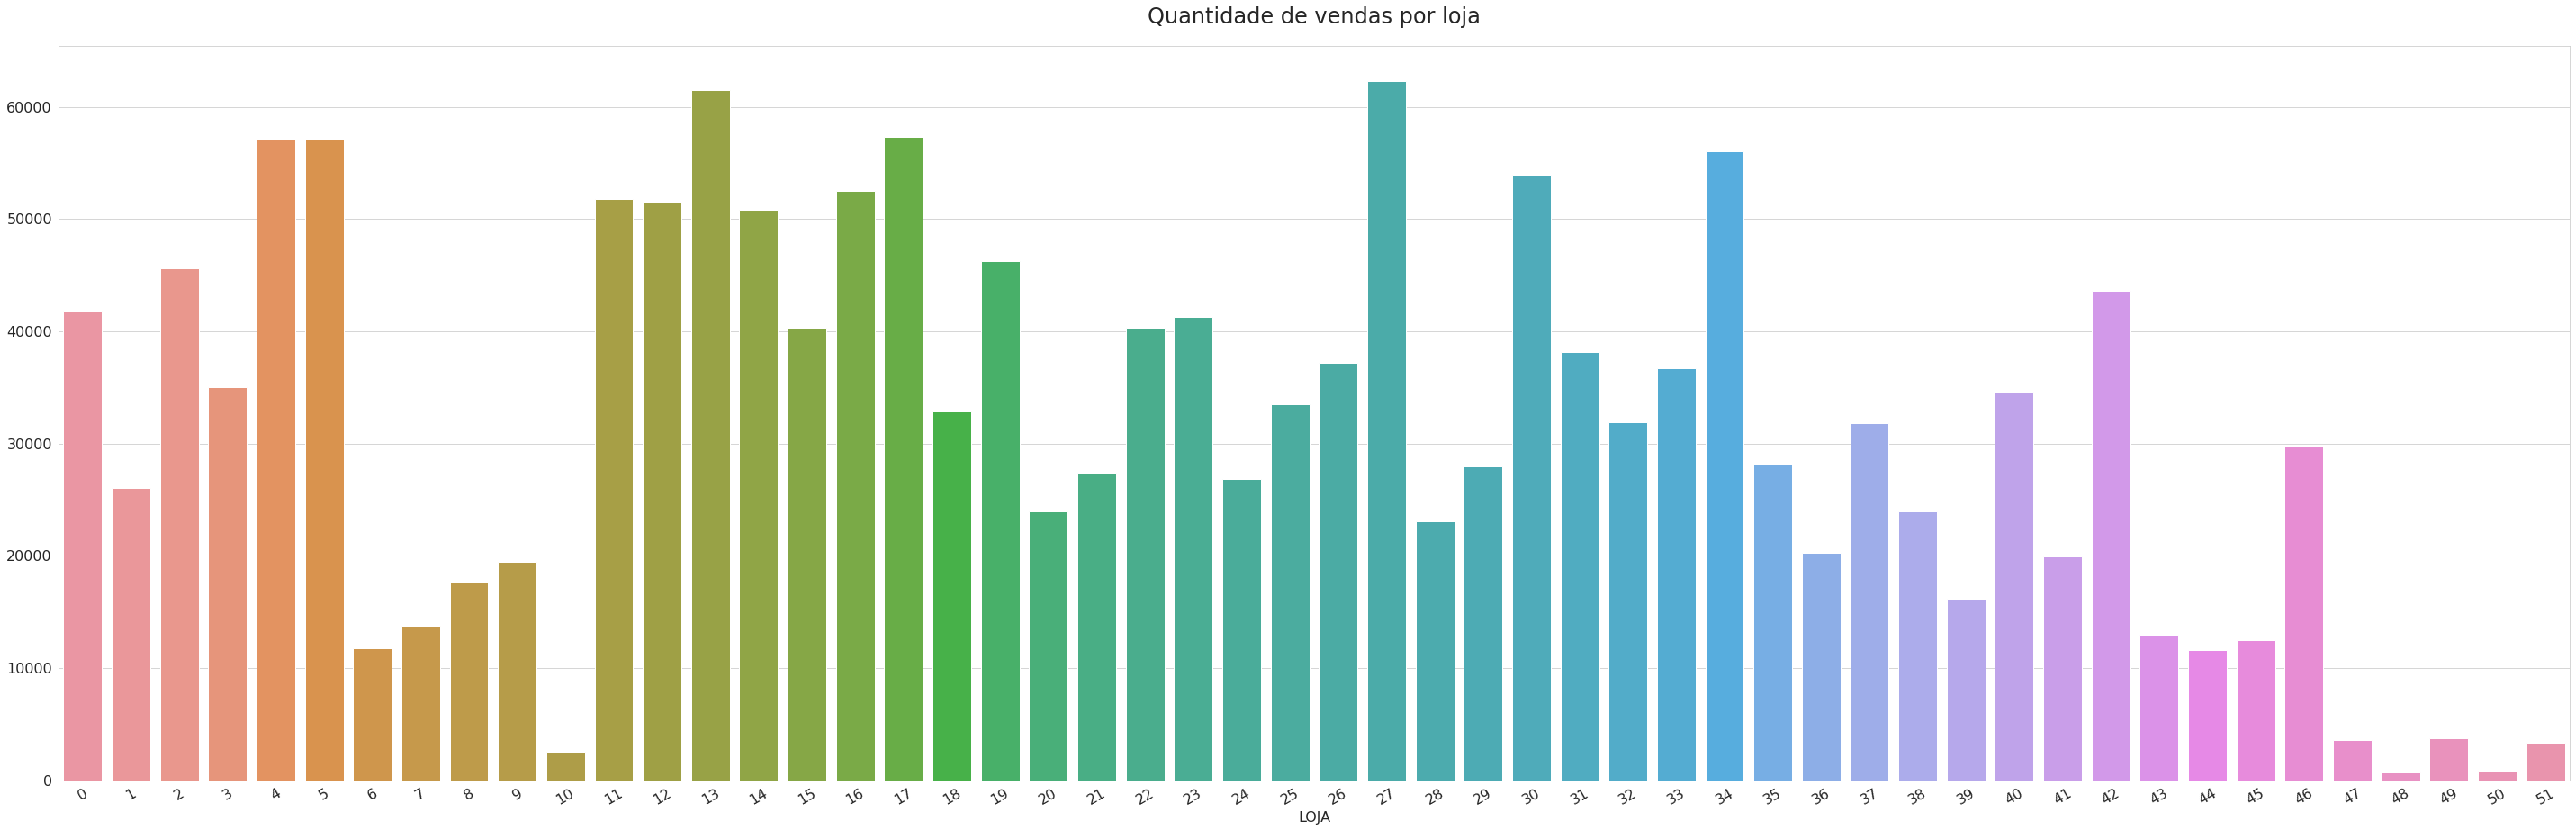

In [12]:
fig, ax = pyplot.subplots(figsize=(50, 15))

sns.barplot(x=store_sells.index, y='QTD_TOTAL_VENDAS', data=store_sells)

plt.ylabel("")

plt.xlabel("LOJA", fontsize=16)

plt.xticks(fontsize=16, rotation=30, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Quantidade de vendas por loja", pad=25, fontsize=24)

plt.show()

<a id="section-three-two"></a>

### 4.2. Visualizando a receita total gerada por cada loja

In [13]:
# Dataset para visualizar a receita total gerada em cada loja durante todo o período do Dataset
store_sells = pd.DataFrame(df.groupby("LOJA").sum()['VALOR'])

store_sells.head()

,VALOR
LOJA,
0,9632786.69
1,2850894.12
2,4110732.75
3,2847773.85
4,4648800.49


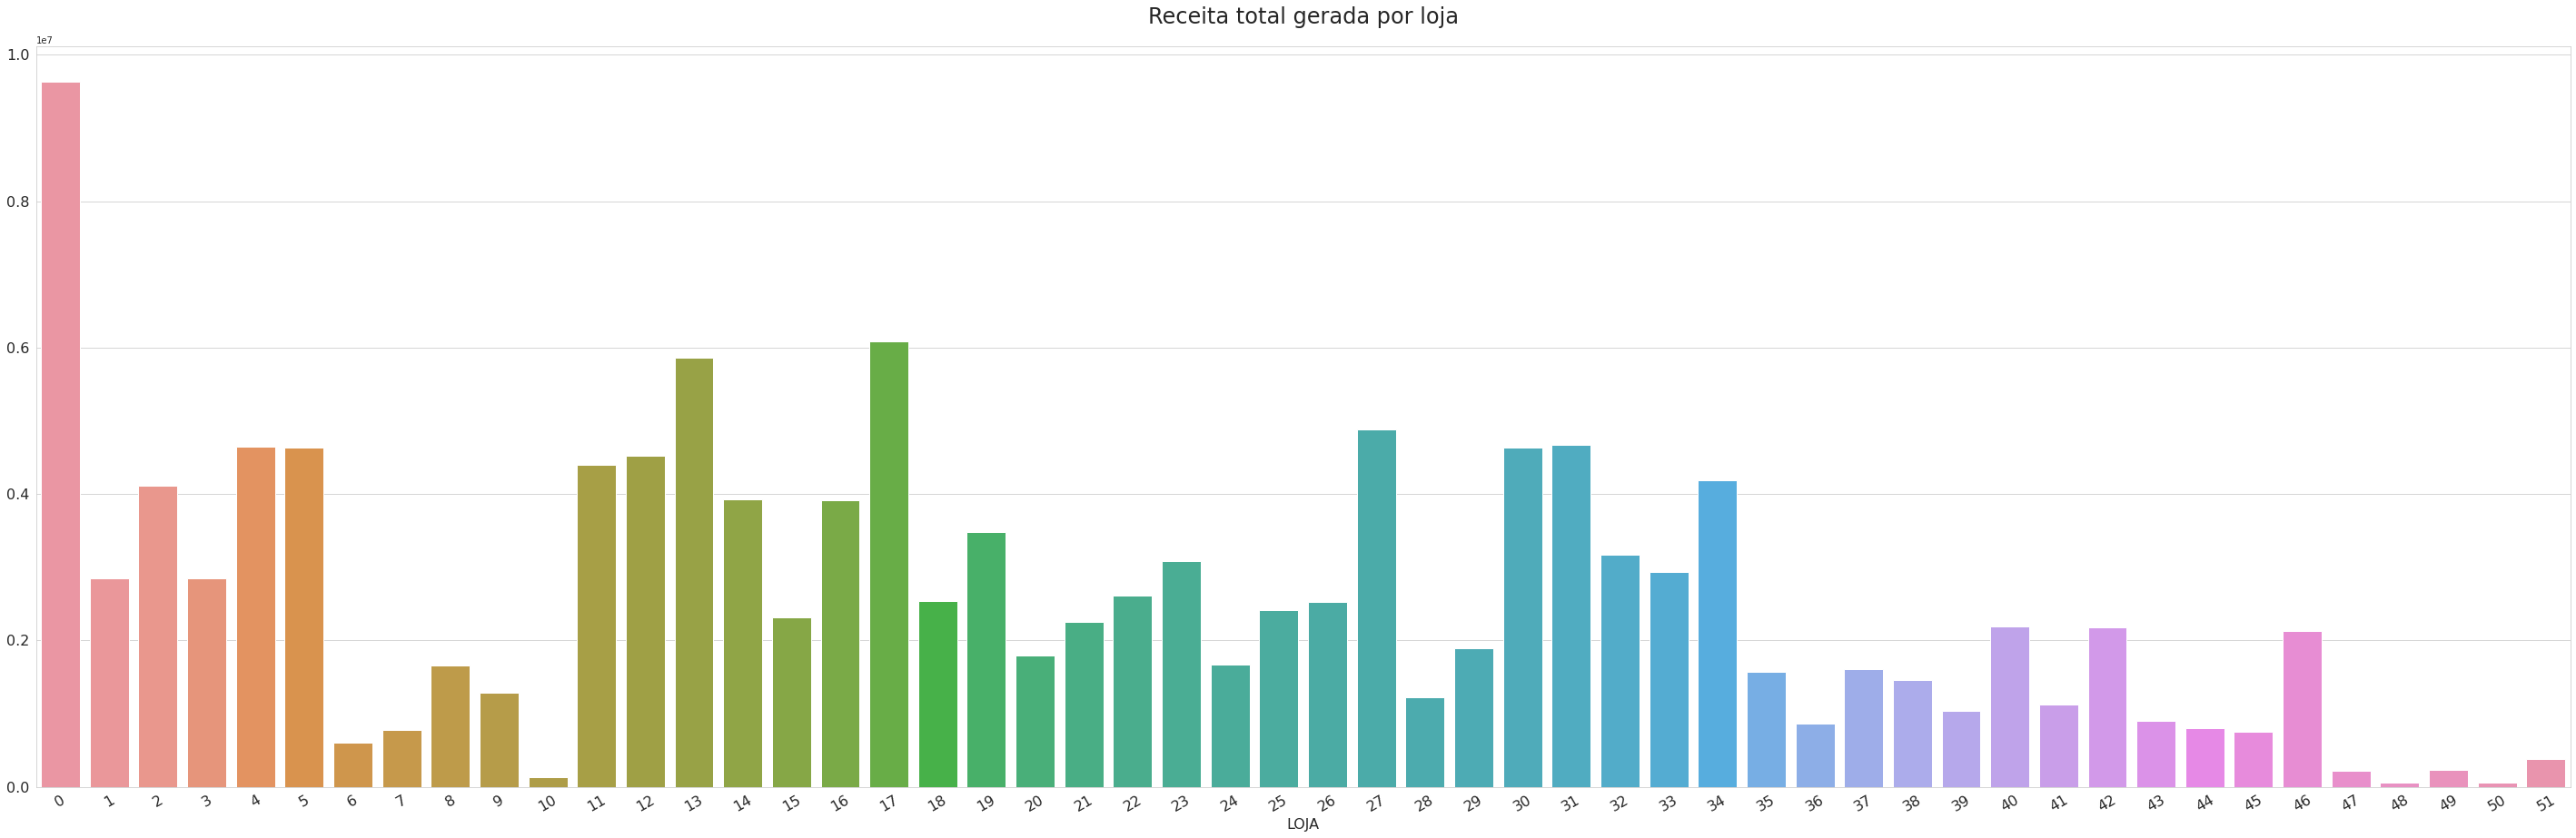

In [14]:
fig, ax = pyplot.subplots(figsize=(50, 15))

sns.barplot(x=store_sells.index, y='VALOR', data=store_sells)

plt.ylabel("")

plt.xlabel("LOJA", fontsize=16)

plt.xticks(fontsize=16, rotation=30, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Receita total gerada por loja", pad=25, fontsize=24)

plt.show()

<a id="section-three-three"></a>

### 4.3. Analisando os canais de vendas mais recorrentes



In [15]:
# Dataset para visualizar quantas vendas foram realizadas por cada tipo de canal durante todo o período do Dataset
channel_sells = df['CANAL'].value_counts()

channel_sells.head()

FIS           1496836
ECM            108128
TELEVENDAS      13473
WHATSAPP         8034
IFOOD            4141
Name: CANAL, dtype: int64

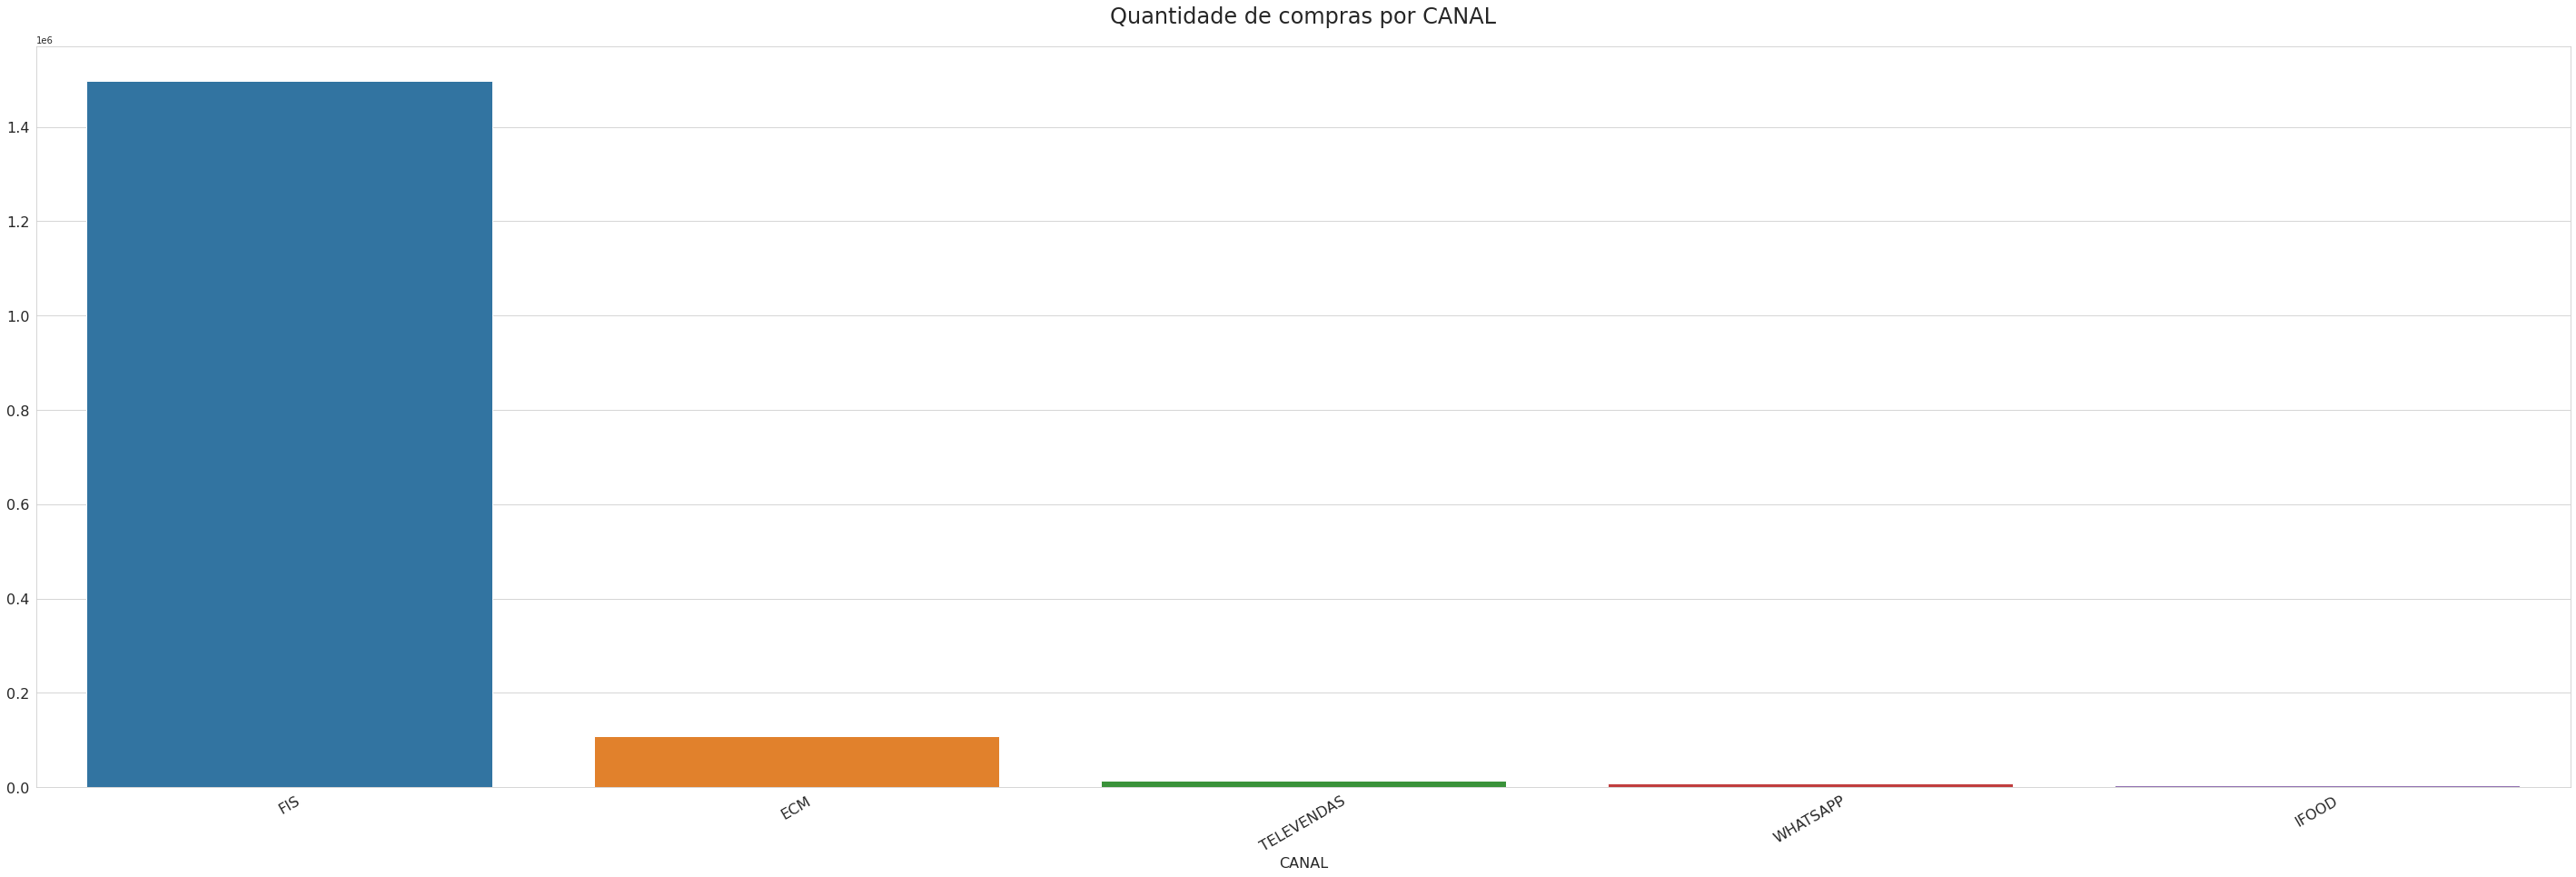

In [16]:
fig, ax = pyplot.subplots(figsize=(50, 15))

store_sells_plot = sns.barplot(x=channel_sells.index, y=channel_sells.values)

plt.ylabel("")

plt.xlabel("CANAL", fontsize=16)

plt.xticks(fontsize=16, rotation=30, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Quantidade de compras por CANAL", pad=25, fontsize=24)

plt.show(store_sells_plot)

<a id="section-three-four"></a>

### 4.4. Analisando a quantidade de vendas por dia


In [17]:
# Dataset para visualizar quantas compras foram realizadas por dia durante todo o período do Dataset
date_count_df = df.groupby('DT_VENDA').count()['ID_VENDA']

date_count_df.head()

DT_VENDA
2020-01-02    3163
2020-01-03    3819
2020-01-04    2686
2020-01-05     148
2020-01-06    4416
Name: ID_VENDA, dtype: int64

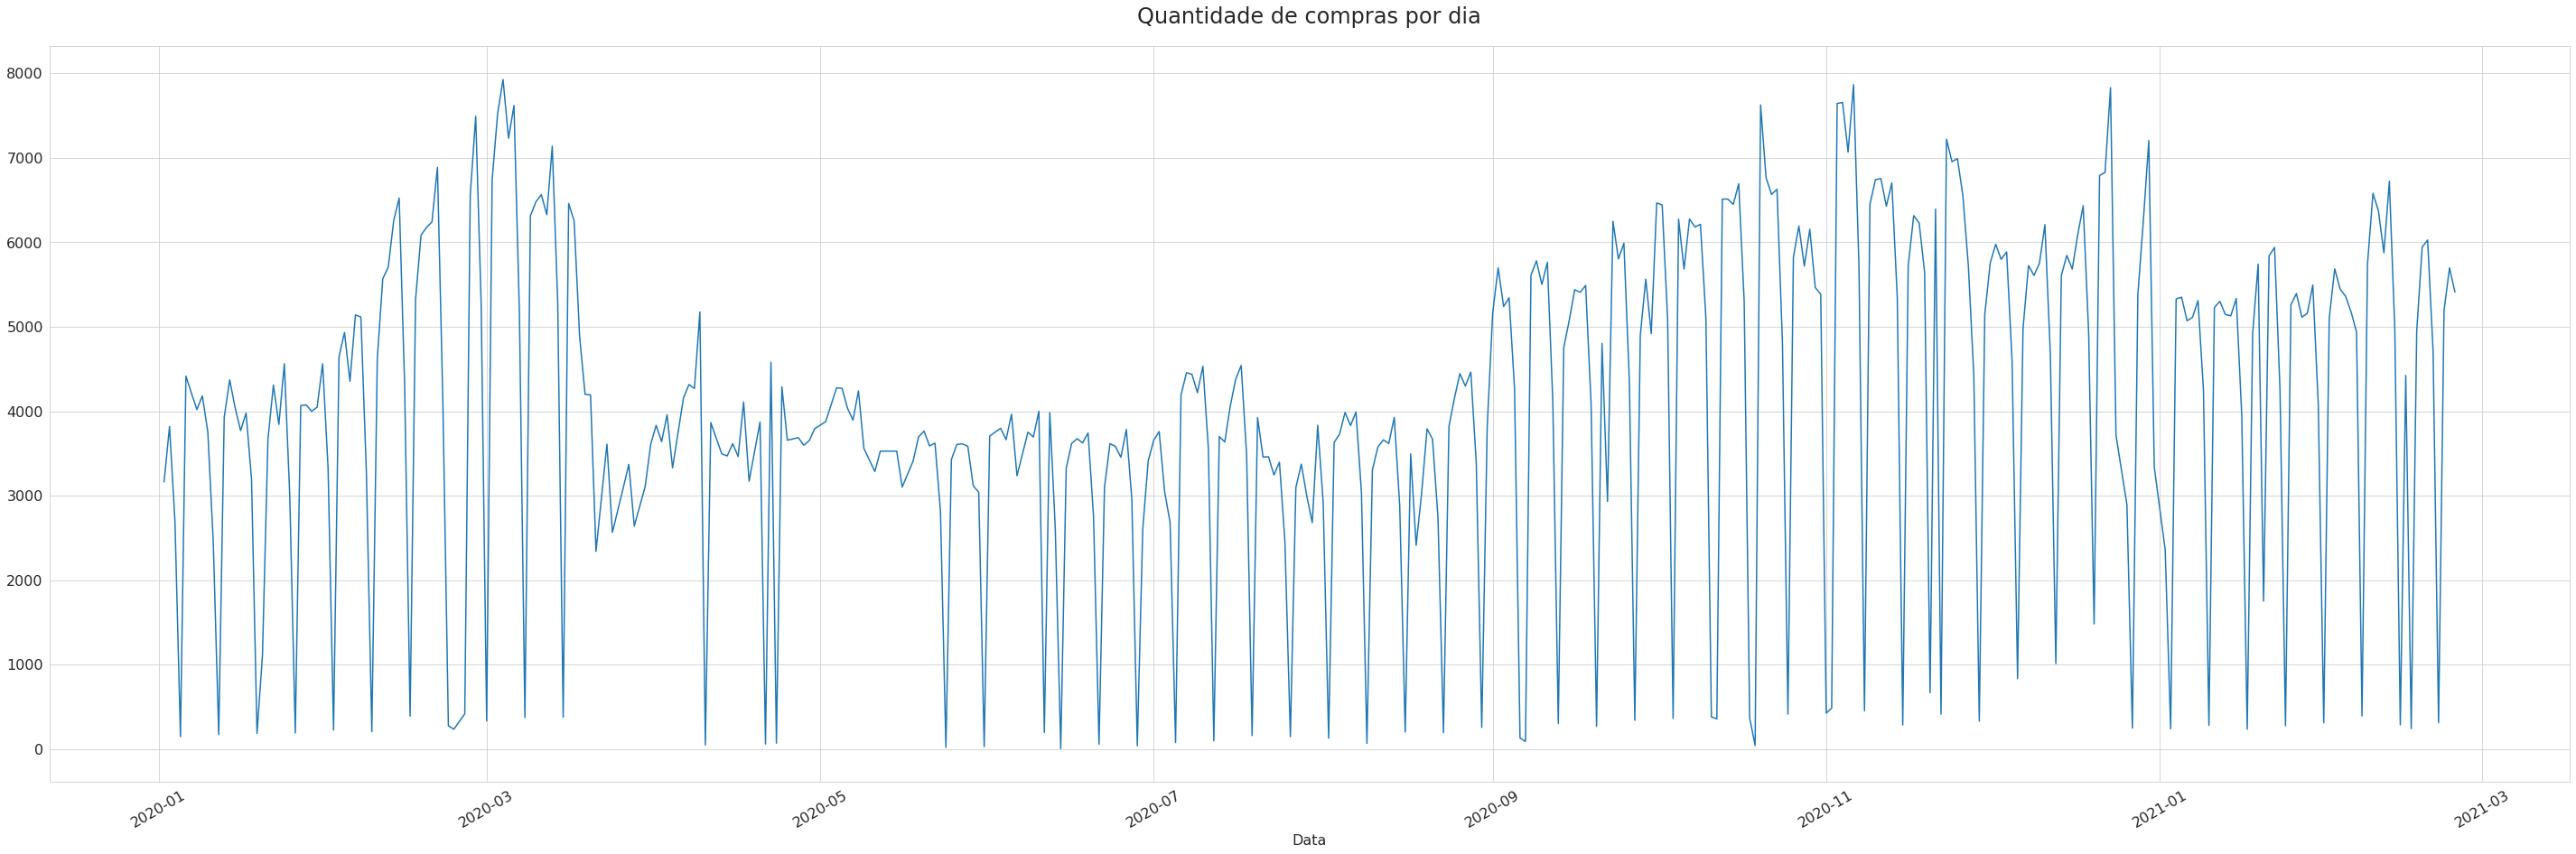

In [18]:
fig, ax = pyplot.subplots(figsize=(50, 15))

sns.lineplot(data=date_count_df)

plt.ylabel("")

plt.xlabel("Data", fontsize=16)

plt.xticks(fontsize=16, rotation=30, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Quantidade de compras por dia", pad=25, fontsize=24)

plt.show()

<a id="section-three-five"></a>

### 4.5. Analisando a receita total por dia

In [19]:
# Dataset para visualizar a receita gerada por dia durante todo o período do Dataset
date_revenue_sum_df = df.groupby('DT_VENDA').sum()['VALOR']

date_revenue_sum_df.head()

DT_VENDA
2020-01-02    146558.77
2020-01-03    180531.07
2020-01-04    146222.50
2020-01-05      7819.86
2020-01-06    202280.80
Name: VALOR, dtype: float64

In [20]:
# Dataset para visualizar a média de receita gerada por dia durante todo o período do Dataset
date_revenue_mean_df = df.groupby('DT_VENDA').mean()['VALOR']

date_revenue_mean_df.head()

DT_VENDA
2020-01-02    46.335368
2020-01-03    47.271817
2020-01-04    54.438757
2020-01-05    52.836892
2020-01-06    45.806341
Name: VALOR, dtype: float64

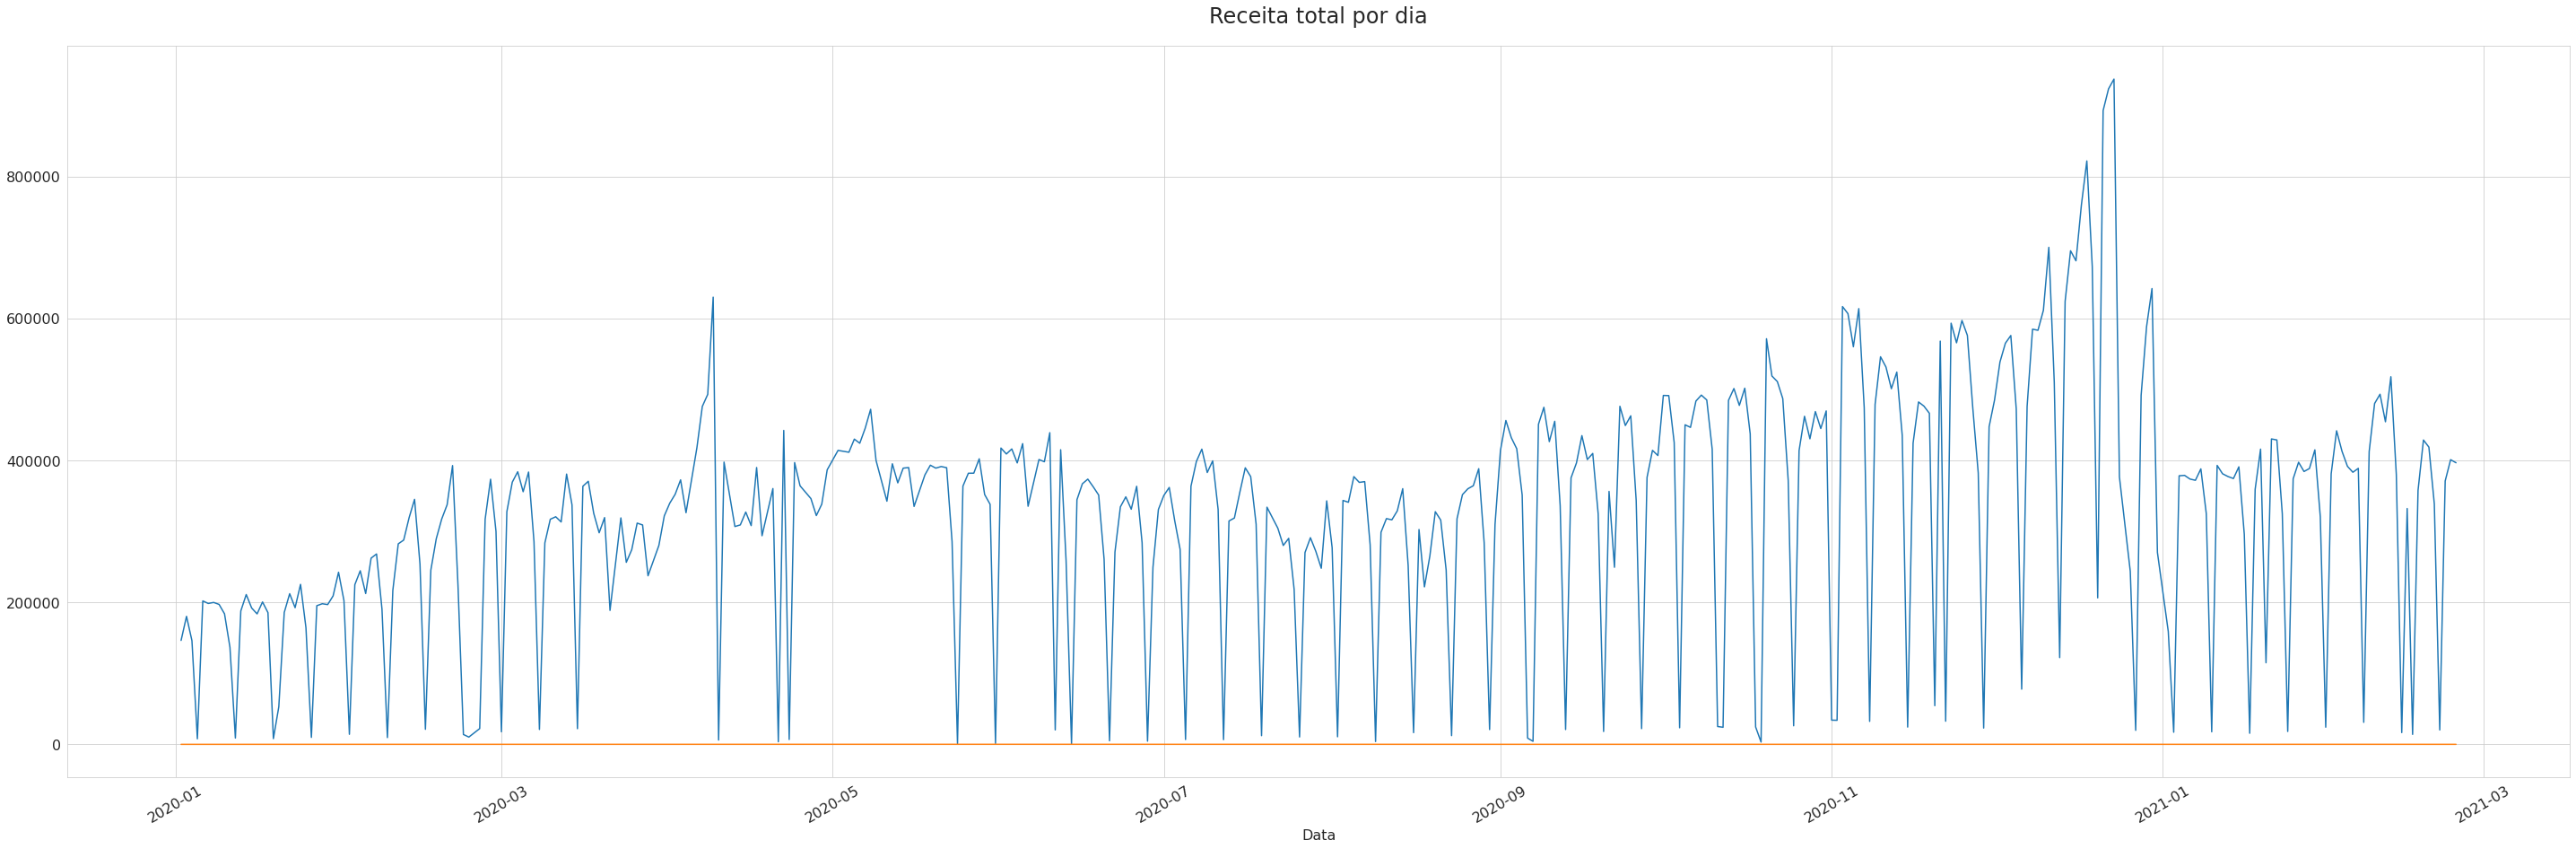

In [21]:
fig, ax = pyplot.subplots(figsize=(50, 15))

sns.lineplot(data=date_revenue_sum_df)

sns.lineplot(data=date_revenue_mean_df)

plt.ylabel("")

plt.xlabel("Data", fontsize=16)

plt.xticks(fontsize=16, rotation=30, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Receita total por dia", pad=25, fontsize=24)

plt.show()

<a id="section-three-six"></a>

### 4.6. Analisando a correlação entre as variáveis

Iremos analisar a correlação entre as variáveis contínuas do Dataset. 

A **correlação** é uma análise bivariada que mede a força da associação entre duas variáveis ​​e a direção da relação. Em termos da força da relação, o valor do coeficiente de correlação varia entre +1 e -1. Um valor de ± 1 indica um grau de associação entre as duas variáveis. À medida que o valor do coeficiente de correlação vai para 0, a relação entre as duas variáveis ​​será mais fraca. 

Existem vários métodos de correlação, de Perason, Spearman e Kendall. 

Para o método de correlação iremos utilizar a correlação de Pearson.

<AxesSubplot:>

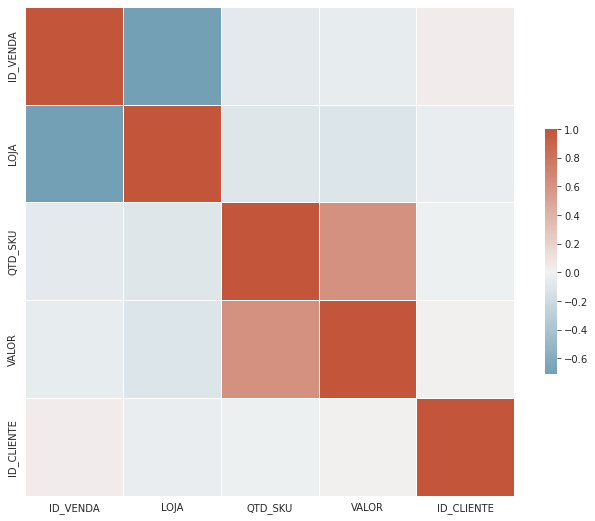

In [22]:
# Computa a matriz de correlação
corr = df.corr()


fifg, ax = plt.subplots(figsize=(11, 9))

# Gerando um colormap customizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

É interessante também analisarmos a relação que a variável *CANAL* tem com o Valor de cada compra.

Para que possamos utilizar esse algorítmo, precisamos criar labels para cada variável categórica. Começaremos por este passo.

In [23]:
# Conversão das variáveis categóricas em numéricas
df_labeled = pd.get_dummies(df)

df_labeled.head()

,ID_VENDA,DT_VENDA,LOJA,QTD_SKU,VALOR,ID_CLIENTE,CANAL_ECM,CANAL_FIS,CANAL_IFOOD,CANAL_TELEVENDAS,CANAL_WHATSAPP
0,1176550,2020-01-02,37,1,9.50,337763,0,1,0,0,0
1,11683461,2020-01-02,15,1,6.64,195687,0,1,0,0,0
2,3326484,2020-01-02,29,5,446.87,56059,0,1,0,0,0
3,7317475,2020-01-02,18,1,6.13,297533,0,1,0,0,0
4,4366938,2020-01-02,23,1,13.17,181284,0,1,0,0,0


<AxesSubplot:>

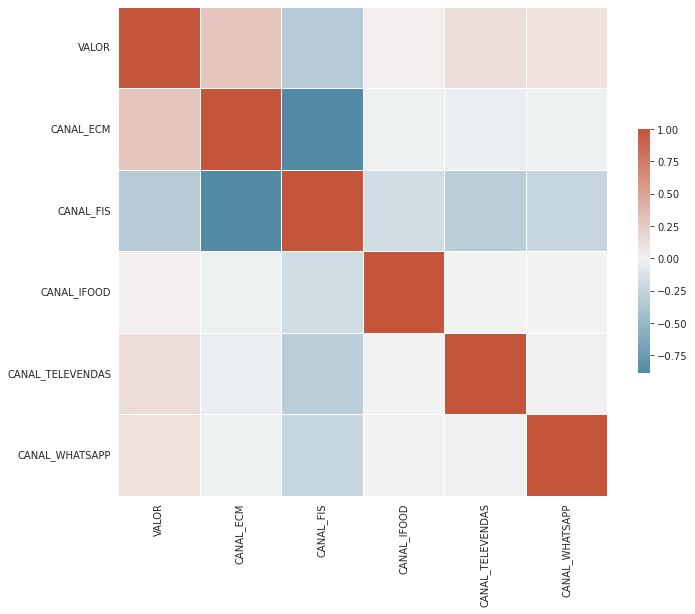

In [24]:
# Computa a matriz de correlação
corr = df_labeled[['VALOR', 'CANAL_ECM', 'CANAL_FIS', 'CANAL_IFOOD', 'CANAL_TELEVENDAS', 'CANAL_WHATSAPP']].corr()


fifg, ax = plt.subplots(figsize=(11, 9))

# Gerando o mapeamento de cores
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<a id="section-four"></a>

### 5. Segmentando os dados

Para o problema de LTV podemos criar várias segmentações. Caso a Retenção dos clientes nas lojas seja interessante, o dado pode ser segmentado baseado na probabilidade de Churn, entre outros métodos. Para este caso, iremos trabalhar com RFM que diz respeito à Recency - Frequency - Monetary Value que em tradução livre se diz respeito à Recência - Frequência  e Valor monetário. 

 - Baixo valor de RFM: Clientes que são menos ativos que outros e não realizam compras frequentes e que gastam pouco - normalmente são visitantes. 

 - Valor médio de RFM: Representa o cliente médio. Ele compra com certa frequência e de forma recente e gera um valor considerável de receita, mas que não chega a ser muito alto. 

 - Alto valor de RFM: Cliente que gera muita receita de forma frequente e de forma recente, esses são os clientes que você não quer perder.

Para isso, iremos calcular a Recência, Frequência e Valor monetário de cada cliente e iremos aplicar um processo de aprendizado não-supervisionado para gerar diferentes cluster para cada valor individual.

Será gerado um Score final que representa o RFM somando cada cluster das variáveis Recência, Frequência e Valor monetário.

In [25]:
# Dataframe que contém os clientes únicos
users_df = pd.DataFrame(df["ID_CLIENTE"].unique(), columns=["ID_CLIENTE"])


users_df.head()

,ID_CLIENTE
0,337763
1,195687
2,56059
3,297533
4,181284


<a id="section-four-one-one"></a>

### 5.1.1 Cálculo da Recência

Iremos calcular a recência do cliente que nada mais é que a diferença de dias em que o usuário realizou sua última transação em relação ao dia mais recente do *Dataset* - 24/02/2021. Quanto maior a recência, menos recente é as compras deste cliente. 

In [26]:
df_max_purchase = df.groupby('ID_CLIENTE')['DT_VENDA'].max().reset_index()

df_max_purchase.columns = ['ID_CLIENTE','DT_COMPRA_MAIS_RECENTE']

df_max_purchase['DT_COMPRA_MAIS_RECENTE'] = pd.to_datetime(df_max_purchase['DT_COMPRA_MAIS_RECENTE'])

df_max_purchase.head()

,ID_CLIENTE,DT_COMPRA_MAIS_RECENTE
0,0,2020-12-02
1,2,2021-01-06
2,3,2020-08-13
3,4,2021-02-08
4,5,2020-04-02


In [27]:
# Compara a última transação do conjunto de dados com as datas da última transação dos IDs de clientes individuais.
df_max_purchase['RECENCIA'] = (df_max_purchase['DT_COMPRA_MAIS_RECENTE'].max() - df_max_purchase['DT_COMPRA_MAIS_RECENTE']).dt.days

df_max_purchase.head()

,ID_CLIENTE,DT_COMPRA_MAIS_RECENTE,RECENCIA
0,0,2020-12-02,84
1,2,2021-01-06,49
2,3,2020-08-13,195
3,4,2021-02-08,16
4,5,2020-04-02,328


In [28]:
# mesclar este dataframe ao nosso dataframe de usuários únicos
users_df = pd.merge(users_df, df_max_purchase[['ID_CLIENTE','RECENCIA']], on='ID_CLIENTE')

users_df.head()

,ID_CLIENTE,RECENCIA
0,337763,1
1,195687,75
2,56059,25
3,297533,21
4,181284,15


<a id="section-four-one-two"></a>

### 5.1.2 Atribuindo um Score para a Recência

Iremos aplicar a clusterização por K-means para atribuir um score para a recência. Para que isto ocorra de forma otimizada, iremos verificar quantos cluster são necessários para termos o melhor trade-off do algorítmo K-means utilizando o método de Elbow. 

"O método Elbow se trata de uma técnica interessante para encontrar o valor ideal do parâmetro k. Basicamente o que o método faz é testar a variância dos dados em relação ao número de clusters. É considerado um valor ideal de k quando o aumento no número de clusters não representa um valor significativo de ganho." - Mineirando dados

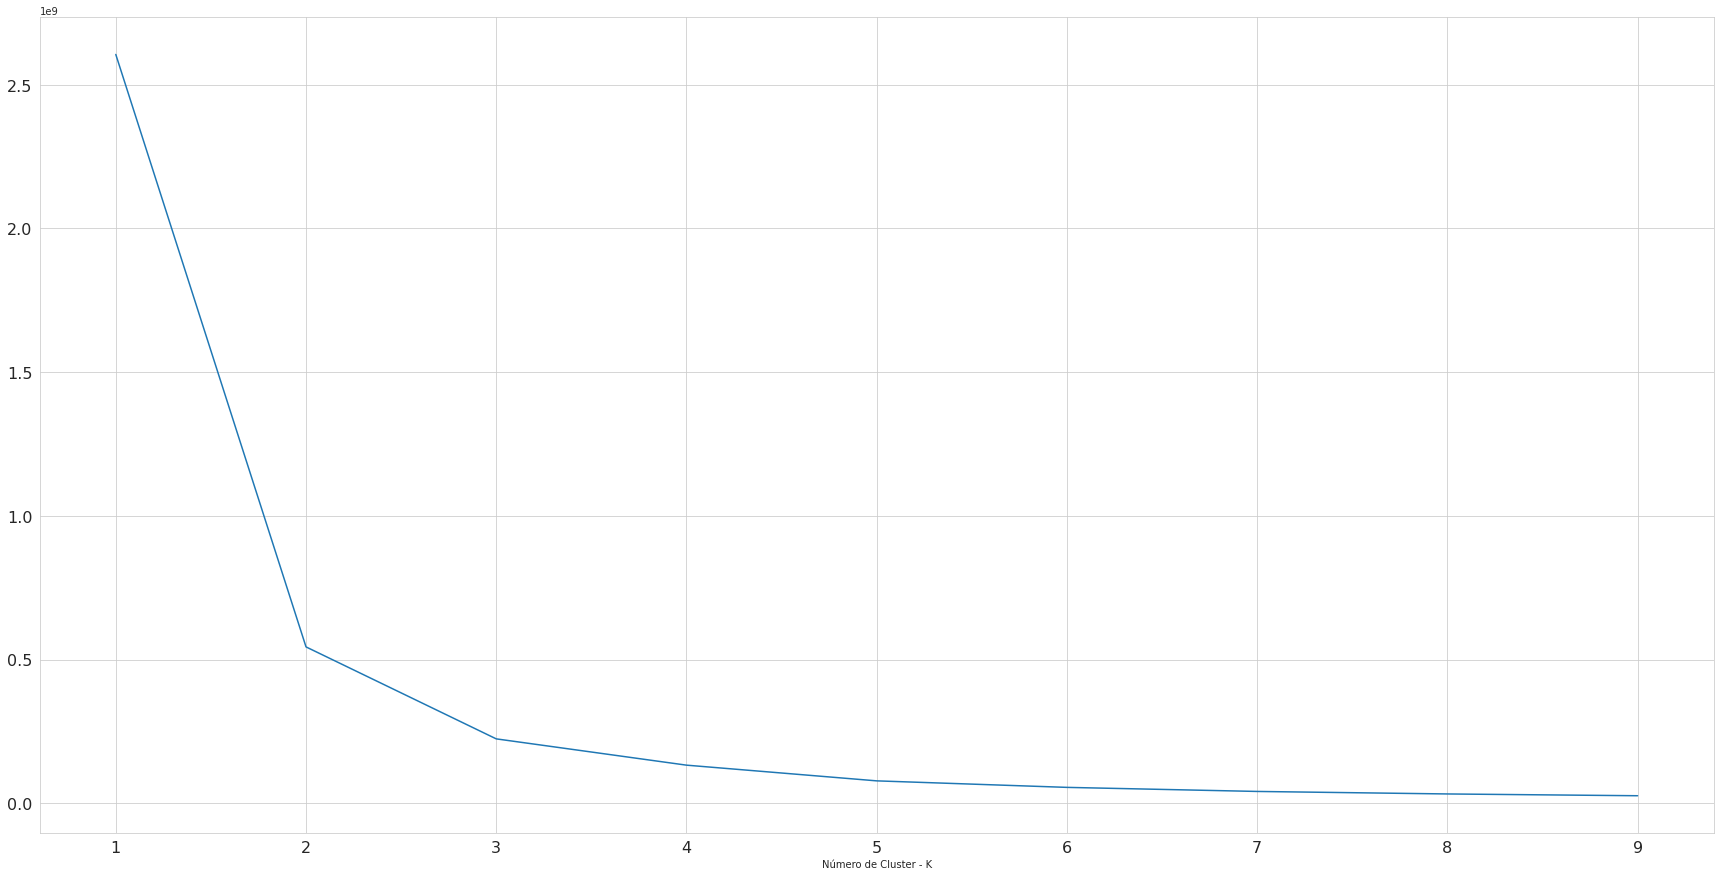

In [29]:
sse={} # Erro

recency_df = users_df[['RECENCIA']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency_df)

    # Nome dos clusters relativos ao valor da recência
    recency_df["CLUSTERS"] = kmeans.labels_  

    # Erro correspondente aos clusters
    sse[k] = kmeans.inertia_ 



fig, ax = pyplot.subplots(figsize=(30, 15))

sns.lineplot(x=list(sse.keys()), y=list(sse.values()))

plt.xlabel("Número de Cluster - K")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.show()



Com isto, podemos determinar que K = 4 nos dá uma clusterização mais otimizada.

In [30]:
# Construindo 4 clusters para a recência e colocando no dataframe
kmeans = KMeans(n_clusters=4)

users_df['CLUSTER_RECENCIA'] = kmeans.fit_predict(users_df[['RECENCIA']])

users_df.head()

,ID_CLIENTE,RECENCIA,CLUSTER_RECENCIA
0,337763,1,0
1,195687,75,2
2,56059,25,0
3,297533,21,0
4,181284,15,0


In [31]:
# Visualizando dados estatísticos da recência para cada cluster criado.
users_df.groupby('CLUSTER_RECENCIA')['RECENCIA'].describe()

,count,mean,std,min,25%,50%,75%,max
CLUSTER_RECENCIA,,,,,,,,
0,106542.0,20.033020,16.209735,0.0,6.0,16.0,30.0,60.0
1,22660.0,214.672065,37.084868,158.0,179.0,216.0,249.0,275.0
2,54434.0,100.789562,26.892138,62.0,77.0,98.0,121.0,157.0
3,26633.0,336.902114,35.527650,277.0,305.0,344.0,361.0,419.0


Para o cálculo do RFM é interassante que os clusters em relação à recência estejam ordenados de forma decrescente em relação a recência, em que o maior cluster corresponda ao cliente com uma boa recência (com um menor valor de recência). 

In [32]:
# Método que ordena o cluster
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()

    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)

    df_new['index'] = df_new.index

    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)

    df_final = df_final.drop([cluster_field_name],axis=1)

    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

In [33]:
# Ordenando os clusters da recência
users_df = order_cluster('CLUSTER_RECENCIA', 'RECENCIA', users_df, False)

users_df.head()


,ID_CLIENTE,RECENCIA,CLUSTER_RECENCIA
0,337763,1,3
1,56059,25,3
2,297533,21,3
3,181284,15,3
4,23450,1,3


In [34]:
# Visualizando dados estatísticos da recência para cada cluster criado.
users_df.groupby('CLUSTER_RECENCIA')['RECENCIA'].describe()


,count,mean,std,min,25%,50%,75%,max
CLUSTER_RECENCIA,,,,,,,,
0,26633.0,336.902114,35.527650,277.0,305.0,344.0,361.0,419.0
1,22660.0,214.672065,37.084868,158.0,179.0,216.0,249.0,275.0
2,54434.0,100.789562,26.892138,62.0,77.0,98.0,121.0,157.0
3,106542.0,20.033020,16.209735,0.0,6.0,16.0,30.0,60.0


In [35]:
# Visualizando a quantidade de clientes pertencentes a cada cluster
display(users_df['CLUSTER_RECENCIA'].value_counts(ascending=True))

1     22660
0     26633
2     54434
3    106542
Name: CLUSTER_RECENCIA, dtype: int64

In [36]:
# Criando um label pra a melhor visualização dos dados relativos aos clusters da recência
users_df['LABEL_RECENCIA'] = 'Alta'

users_df.loc[users_df['CLUSTER_RECENCIA'] == 0, 'LABEL_RECENCIA'] = 'Muito Baixa' 

users_df.loc[users_df['CLUSTER_RECENCIA'] == 1, 'LABEL_RECENCIA'] = 'Baixa' 

users_df.loc[users_df['CLUSTER_RECENCIA'] == 2, 'LABEL_RECENCIA'] = 'Média' 

recency_values_count = users_df['LABEL_RECENCIA'].value_counts(ascending=True)

In [37]:
# Visualizando a quantidade de clientes pertencentes a cada cluster
display(users_df['LABEL_RECENCIA'].value_counts(ascending=True))

Baixa           22660
Muito Baixa     26633
Média           54434
Alta           106542
Name: LABEL_RECENCIA, dtype: int64

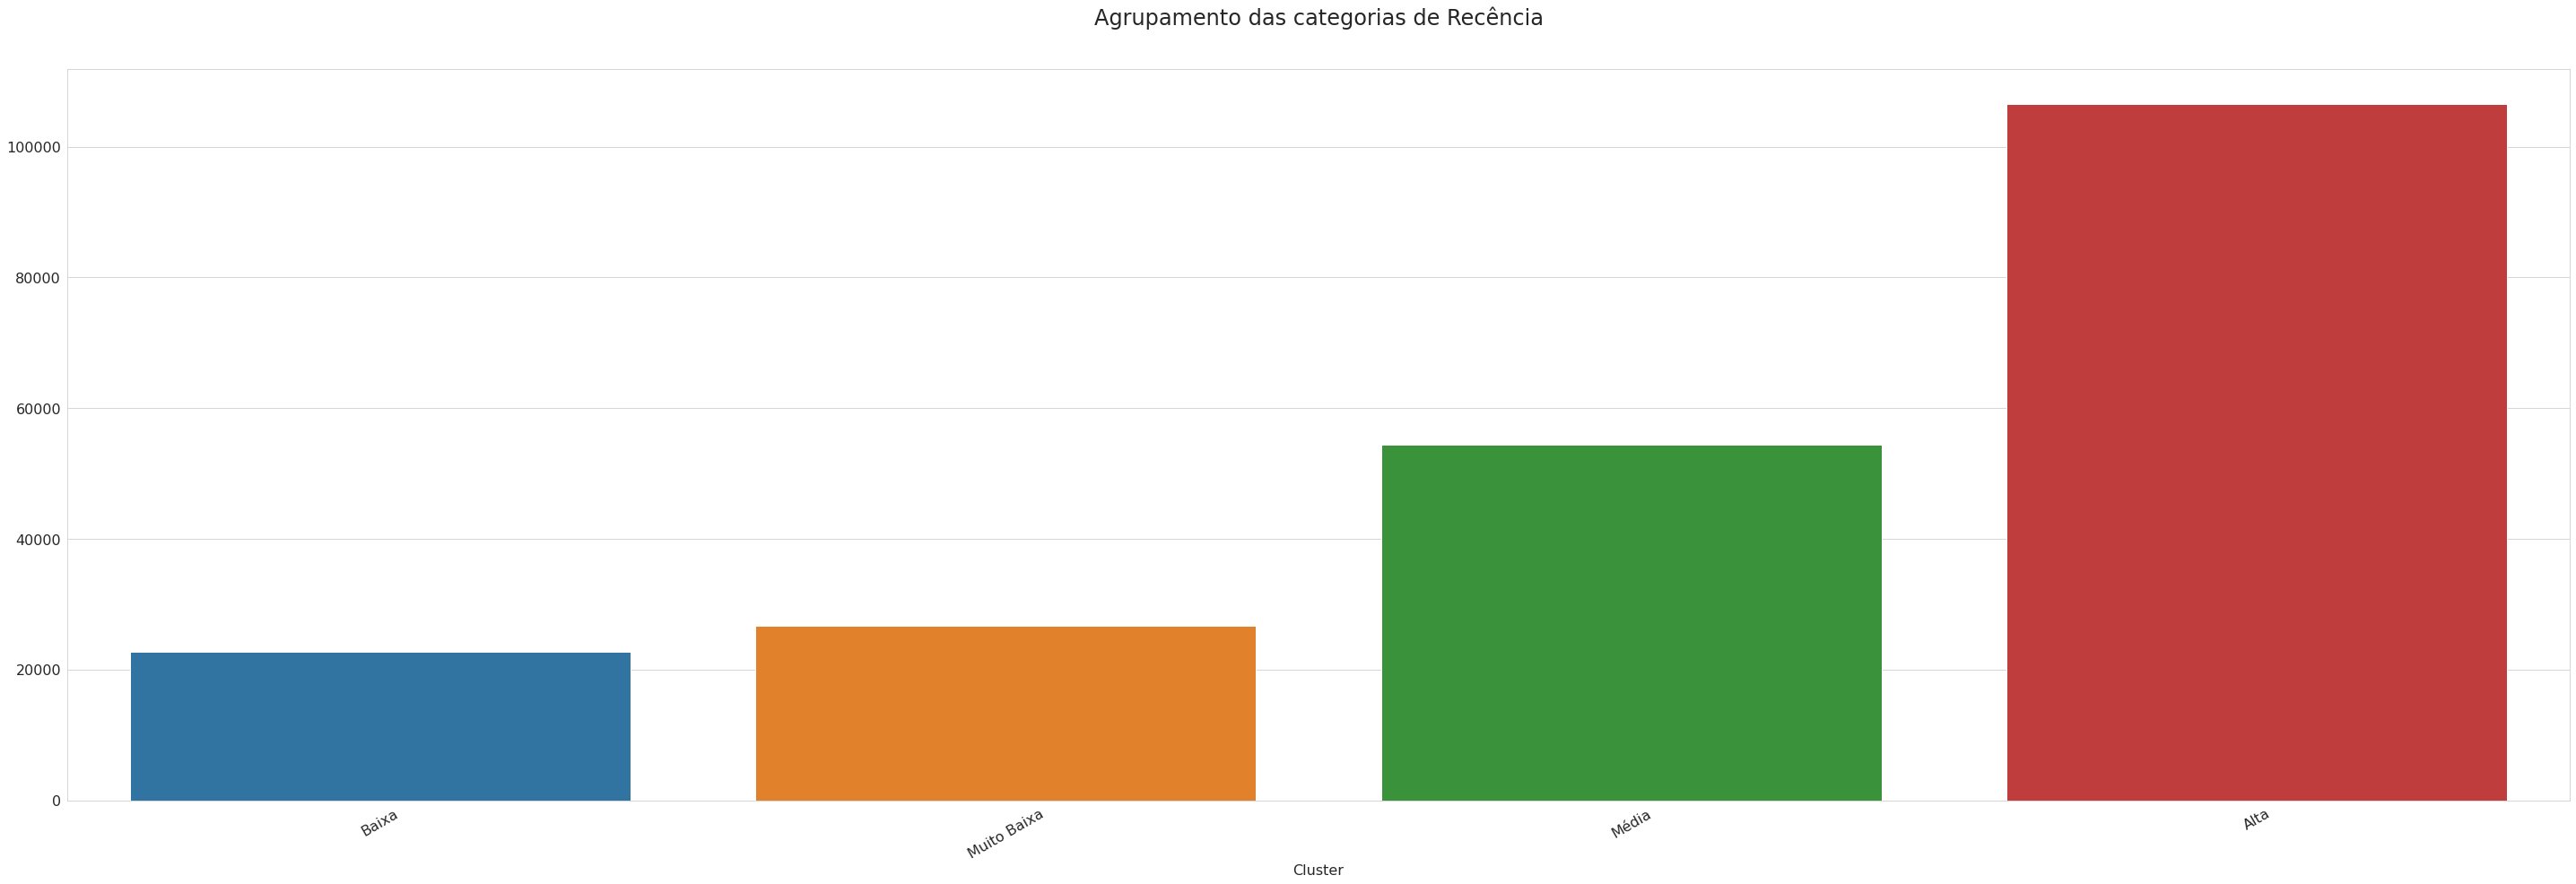

In [38]:
fig, ax = pyplot.subplots(figsize=(50, 15))

label_recency_plot = sns.barplot(x=recency_values_count.index, y=recency_values_count)

plt.ylabel("")

plt.xlabel("Cluster", fontsize=16)

plt.xticks(fontsize=16, rotation=30, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Agrupamento das categorias de Recência", pad=50, fontsize=24)

plt.show(label_recency_plot)

<a id="section-four-two-one"></a>

### 5.2.1. Cálculo da Frequência

A frequência se dá com base no total de compras que cada cliente realizou durante todo o período do *Dataset*.


In [39]:
# Recupera a quantidade de compras por cliente 
frequency_df = df.groupby('ID_CLIENTE')['DT_VENDA'].count().reset_index()

frequency_df.columns = ['ID_CLIENTE','FREQUENCIA']

frequency_df.head()

,ID_CLIENTE,FREQUENCIA
0,0,2
1,2,6
2,3,3
3,4,11
4,5,1


In [40]:
# Mescla este dataframe ao nosso dataframe de usuários únicos
users_df = pd.merge(users_df, frequency_df, on='ID_CLIENTE')

users_df.head()

,ID_CLIENTE,RECENCIA,CLUSTER_RECENCIA,LABEL_RECENCIA,FREQUENCIA
0,337763,1,3,Alta,10
1,56059,25,3,Alta,17
2,297533,21,3,Alta,11
3,181284,15,3,Alta,29
4,23450,1,3,Alta,10


<a id="section-four-two-two"></a>

### 5.2.2. Atribuindo um Score para a Frequência
Semelhante ao caso da Recência, iremos clusterizar os clientes com base em sua frequência. Quanto maior a frequência, mais importante se torna este cliente em relação ao RFM.

Primeiro iremos determina o número K de clusters ideal utilizando o método Elbow.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

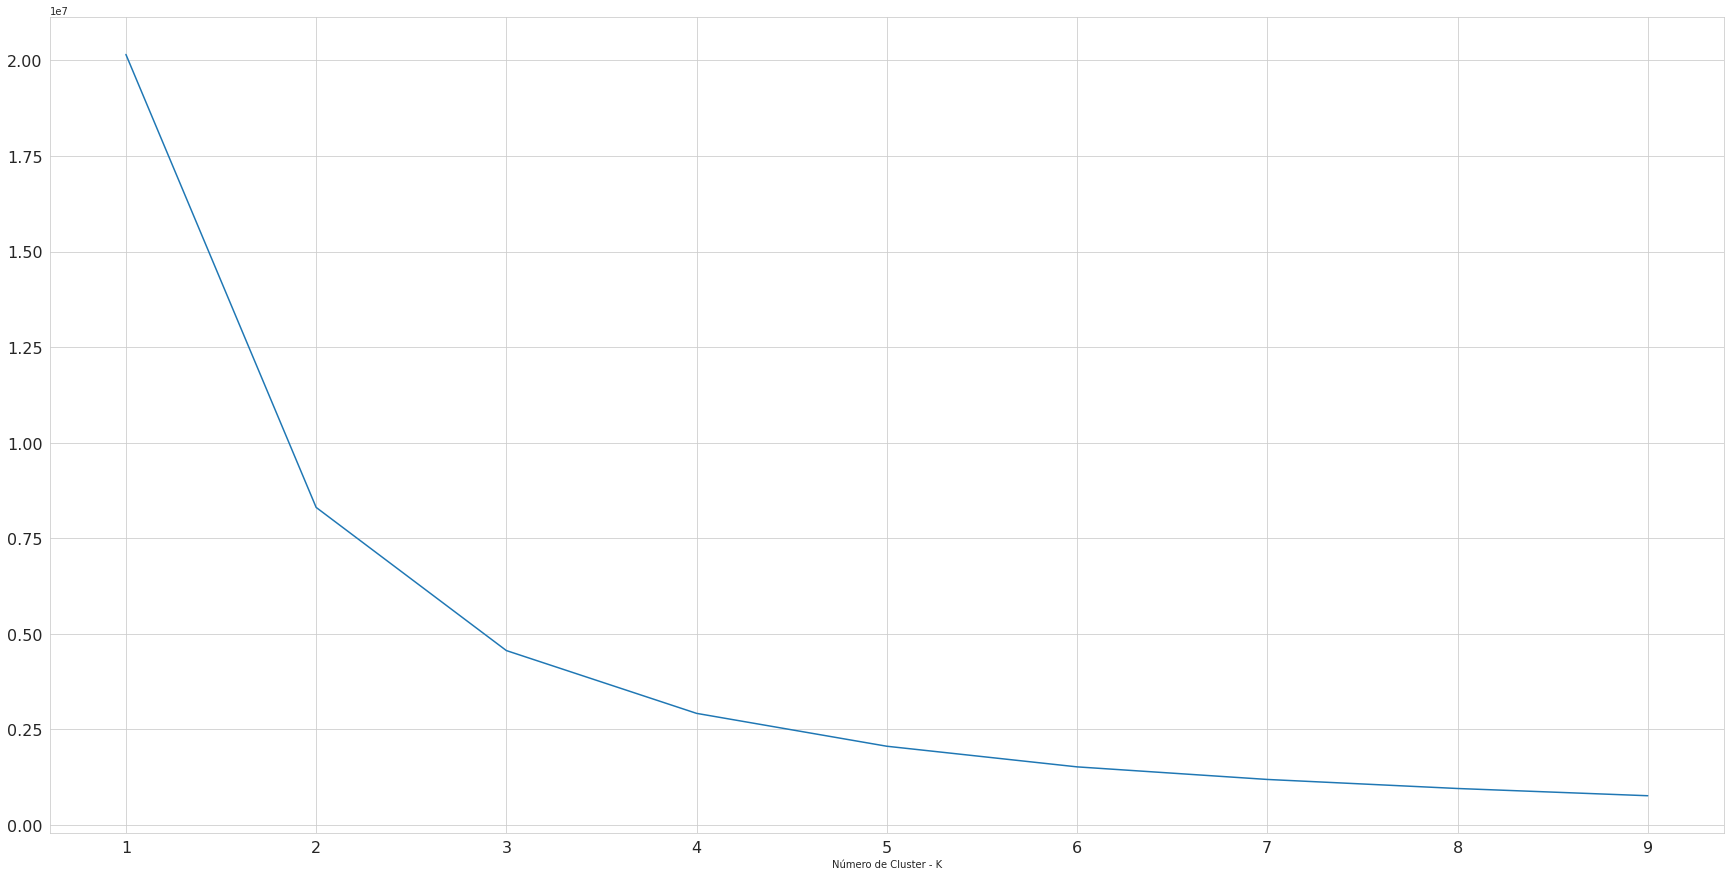

In [41]:
sse={} # Erro

recency_df = users_df[['FREQUENCIA']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency_df)

    # Nome dos clusters relativos ao valor da recência
    recency_df["CLUSTERS"] = kmeans.labels_  

    # Erro correspondente aos clusters
    sse[k] = kmeans.inertia_ 



fig, ax = pyplot.subplots(figsize=(30, 15))

sns.lineplot(x=list(sse.keys()), y=list(sse.values()))

plt.xlabel("Número de Cluster - K")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.show()

Com isto, podemos determinar que K = 4 nos dá uma clusterização mais otimizada.

In [42]:
# Aplicando K-means na coluna de frequência
kmeans = KMeans(n_clusters = 4)

users_df['CLUSTER_FREQUENCIA'] = kmeans.fit_predict(users_df[['FREQUENCIA']])

# Visualizando os dados estatísticos de cada cluster em relação a frequência.
users_df.groupby('CLUSTER_FREQUENCIA')['FREQUENCIA'].describe()


,count,mean,std,min,25%,50%,75%,max
CLUSTER_FREQUENCIA,,,,,,,,
0,13363.0,29.775425,6.802323,22.0,24.0,28.0,34.0,48.0
1,149624.0,3.377807,2.176769,1.0,1.0,3.0,5.0,8.0
2,1842.0,67.380565,23.113731,49.0,53.0,61.0,73.0,360.0
3,45440.0,13.274802,3.532688,9.0,10.0,12.0,16.0,21.0


Para o cálculo do RFM geral é interassante que os clusters em relação à frequência estejam ordenados de forma crescente, em que o maior cluster corresponda ao cliente com uma boa frequência (com um maior valor de compras dentro do período determinado). 

In [43]:
users_df = order_cluster('CLUSTER_FREQUENCIA', 'FREQUENCIA', users_df, True)

# Visualizando os dados estatísticos de cada cluster em relação a frequência.
users_df.groupby('CLUSTER_FREQUENCIA')['FREQUENCIA'].describe()

,count,mean,std,min,25%,50%,75%,max
CLUSTER_FREQUENCIA,,,,,,,,
0,149624.0,3.377807,2.176769,1.0,1.0,3.0,5.0,8.0
1,45440.0,13.274802,3.532688,9.0,10.0,12.0,16.0,21.0
2,13363.0,29.775425,6.802323,22.0,24.0,28.0,34.0,48.0
3,1842.0,67.380565,23.113731,49.0,53.0,61.0,73.0,360.0


In [44]:
# Visualizando a quantidade de clientes pertencentes a cada cluster
display(users_df['CLUSTER_FREQUENCIA'].value_counts(ascending=True))

3      1842
2     13363
1     45440
0    149624
Name: CLUSTER_FREQUENCIA, dtype: int64

In [45]:
# Definindo um label para cada cluster para visualização
users_df['LABEL_FREQUENCIA'] = 'Alta'

users_df.loc[users_df['CLUSTER_FREQUENCIA'] == 0, 'LABEL_FREQUENCIA'] = 'Muito Baixa' 

users_df.loc[users_df['CLUSTER_FREQUENCIA'] == 1, 'LABEL_FREQUENCIA'] = 'Baixa' 

users_df.loc[users_df['CLUSTER_FREQUENCIA'] == 2,'LABEL_FREQUENCIA'] = 'Média' 

In [46]:
# Visualizando a quantidade de clientes pertencentes a cada cluster
display(users_df['LABEL_FREQUENCIA'].value_counts(ascending=True))

Alta             1842
Média           13363
Baixa           45440
Muito Baixa    149624
Name: LABEL_FREQUENCIA, dtype: int64

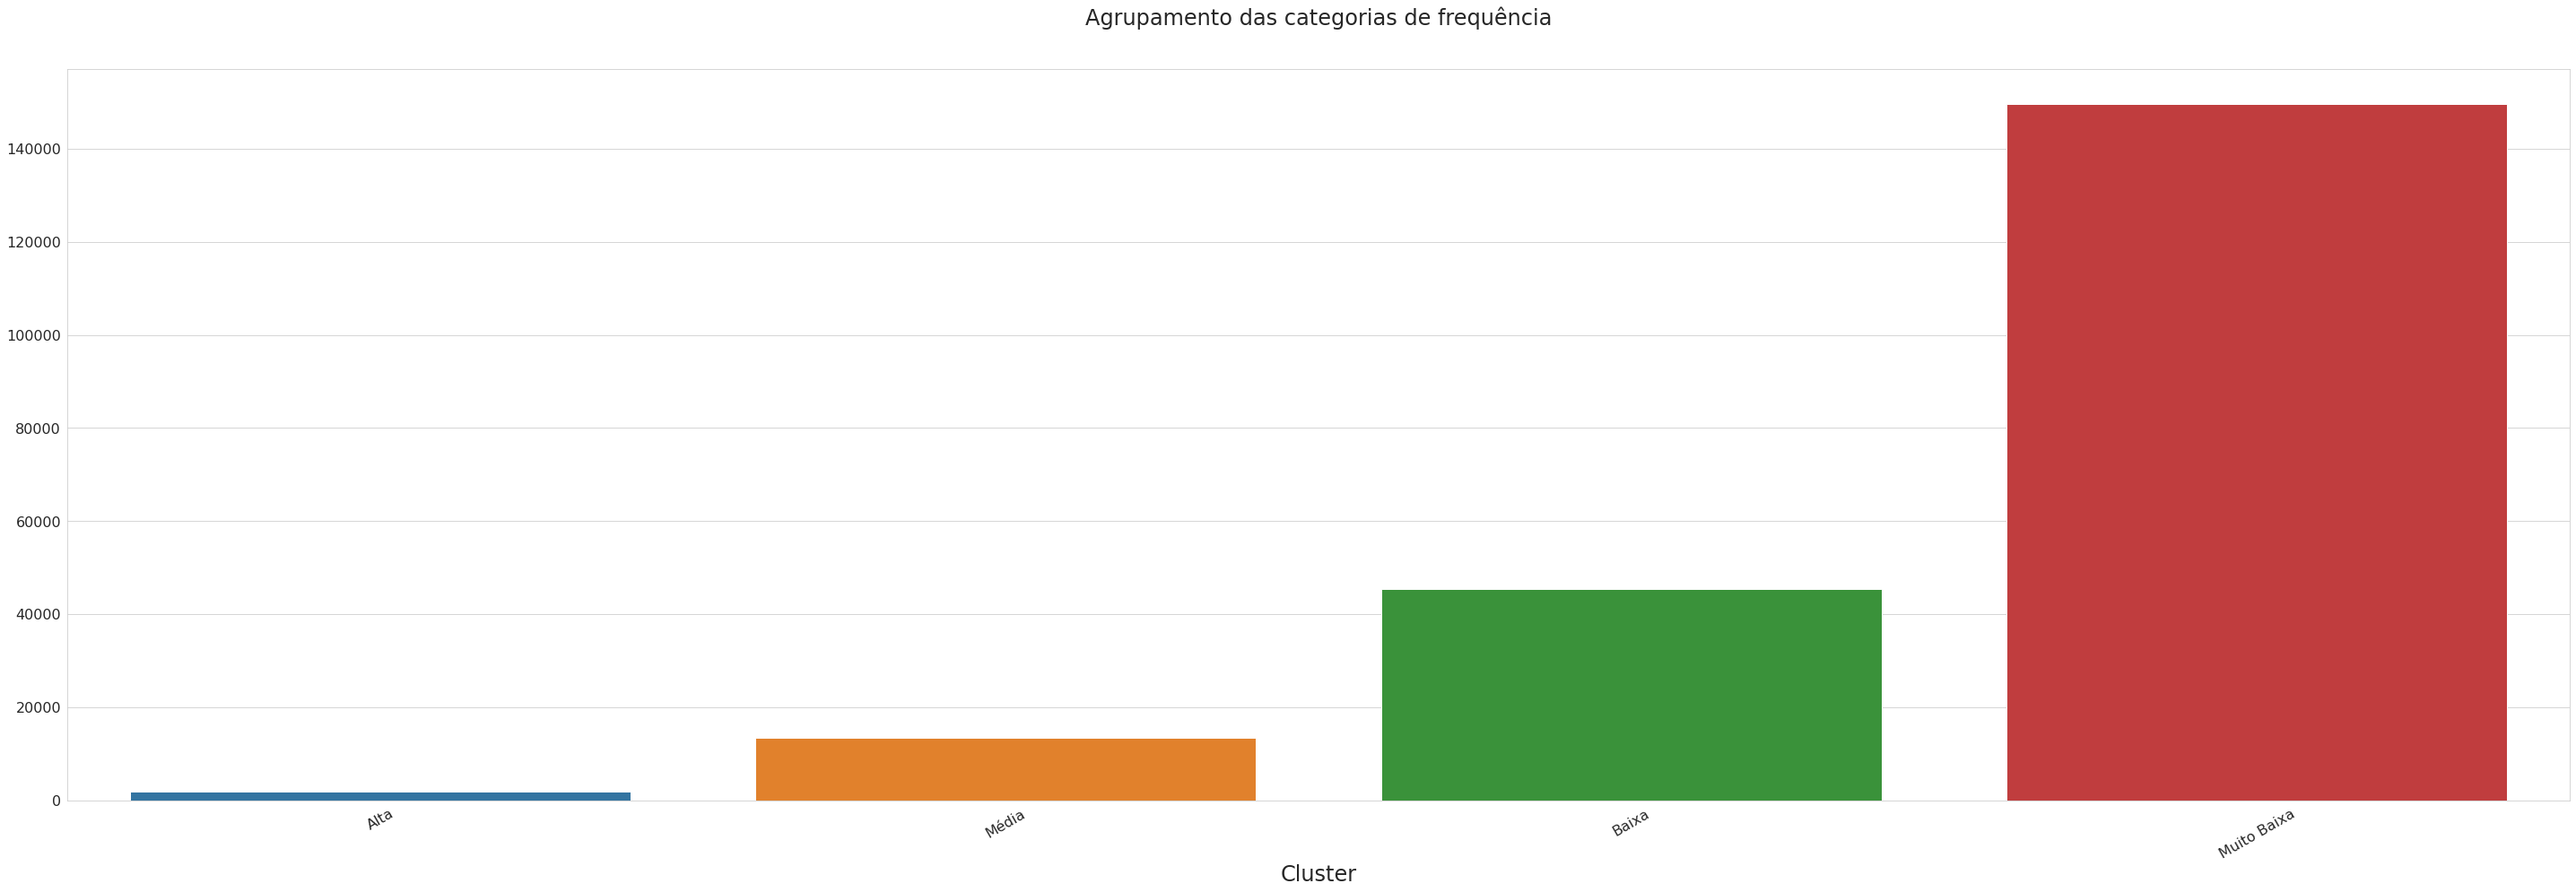

In [47]:
fig, ax = pyplot.subplots(figsize=(50, 15))

label_frequency_plot = sns.barplot(x=users_df['LABEL_FREQUENCIA'].value_counts(ascending=True).index, y=users_df['LABEL_FREQUENCIA'].value_counts(ascending=True))

plt.ylabel("")

plt.xlabel("Cluster", fontsize=24)

plt.xticks(fontsize=16, rotation=30, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Agrupamento das categorias de frequência", pad=50, fontsize=24)

plt.show(label_frequency_plot)

<a id="section-four-three-one"></a>

### 5.3.1 Cálculo da Receita

Iremos analisar como se comportam a receita (valor total) gasto nas lojas por cliente durante todo o período do Dataset.


In [48]:
# Recupera a receita total das compras por cliente 
client_revenue = df[['ID_CLIENTE', 'VALOR']].groupby("ID_CLIENTE").sum()

client_revenue.head()

,VALOR
ID_CLIENTE,
0,636.29
2,662.26
3,215.06
4,1271.87
5,47.19


In [49]:
# Cria um dataset com a receita total das compras por cliente 
client_revenue_df = client_revenue.reset_index()[['ID_CLIENTE', 'VALOR']]

client_revenue_df = client_revenue_df.rename(columns={"ID_CLIENTE": "ID_CLIENTE", "VALOR": "RECEITA"}, errors="raise")

client_revenue_df.head()

,ID_CLIENTE,RECEITA
0,0,636.29
1,2,662.26
2,3,215.06
3,4,1271.87
4,5,47.19


In [50]:
# Mescla este dataframe ao nosso dataframe de usuários únicos
users_df = pd.merge(users_df, client_revenue_df, on='ID_CLIENTE')

users_df.head()

,ID_CLIENTE,RECENCIA,CLUSTER_RECENCIA,LABEL_RECENCIA,FREQUENCIA,CLUSTER_FREQUENCIA,LABEL_FREQUENCIA,RECEITA
0,337763,1,3,Alta,10,1,Baixa,169.41
1,56059,25,3,Alta,17,1,Baixa,1925.52
2,297533,21,3,Alta,11,1,Baixa,998.30
3,23450,1,3,Alta,10,1,Baixa,648.90
4,369108,22,3,Alta,12,1,Baixa,160.40


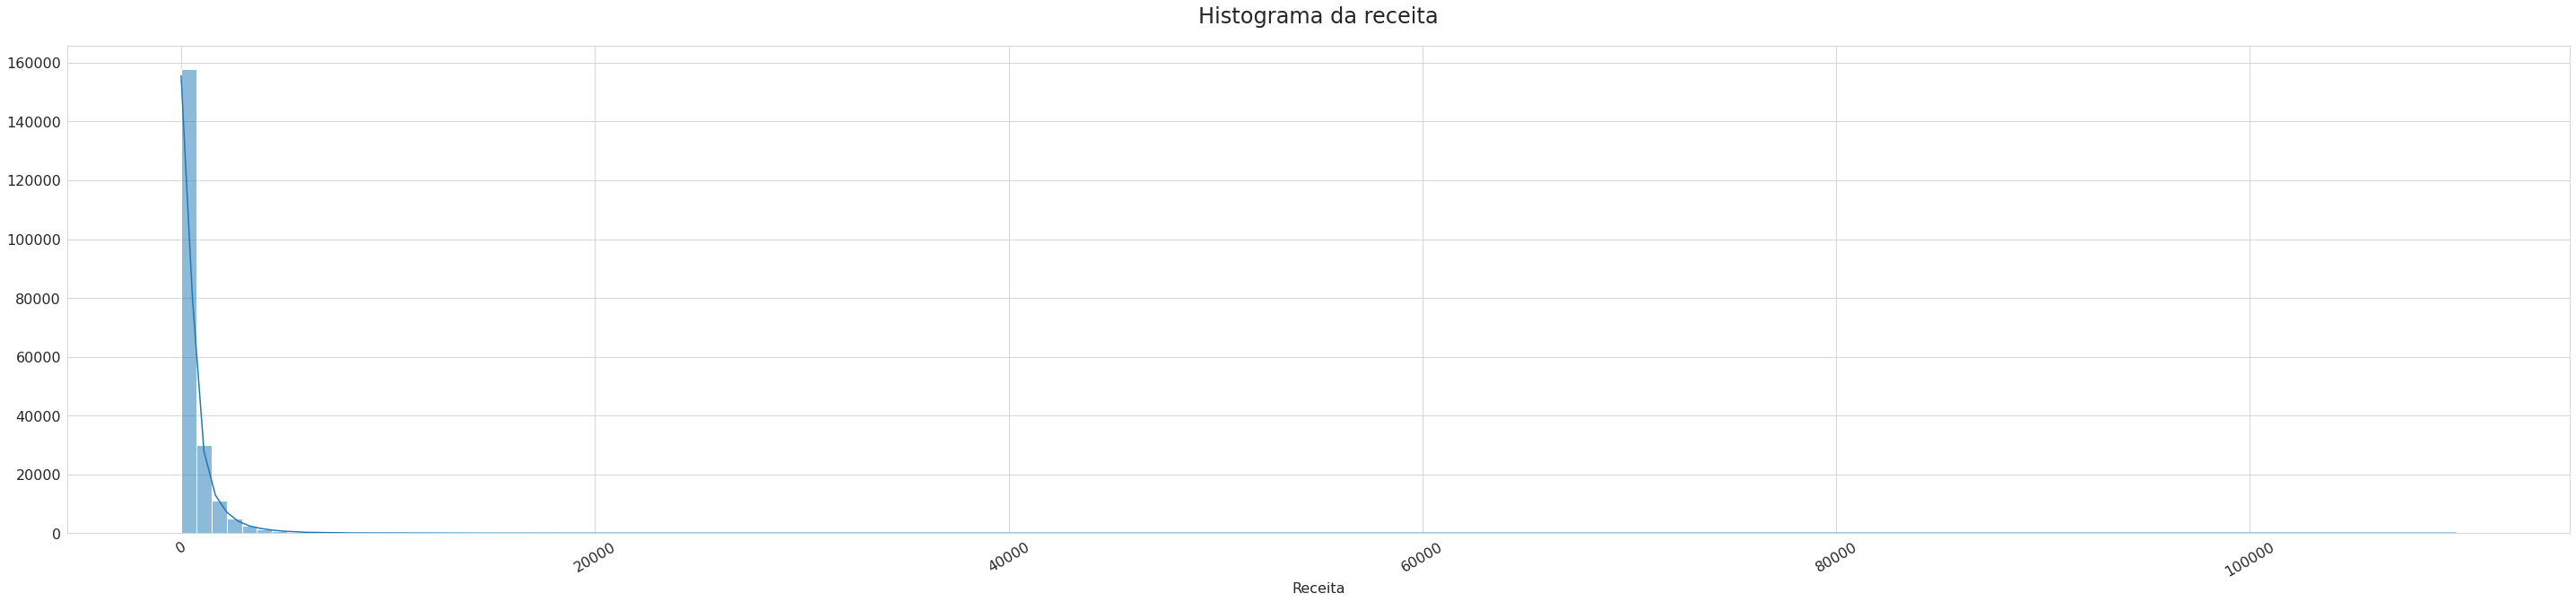

In [51]:
# Analisando a distribuição de receita

fig, ax = pyplot.subplots(figsize=(50, 10))

sns.histplot(data=users_df, x="RECEITA", bins=150, kde=True)

plt.ylabel("")

plt.xlabel("Receita", fontsize=16)

plt.xticks(fontsize=16, rotation=30, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Histograma da receita", pad=25, fontsize=24)

plt.show()

Em primeiro momento iremos preservar todos os dados, por mais que tenhamos um usuário com um gasto exorbitante. 

<a id="section-four-three-two"></a>

### 5.3.2. Atribuindo um Score para a Receita
Assim como nos casos anteriores, iremos clusterizar os clientes com base na receita gerada e determinar o número K ideal de Clusters utilizando o método Elbow.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

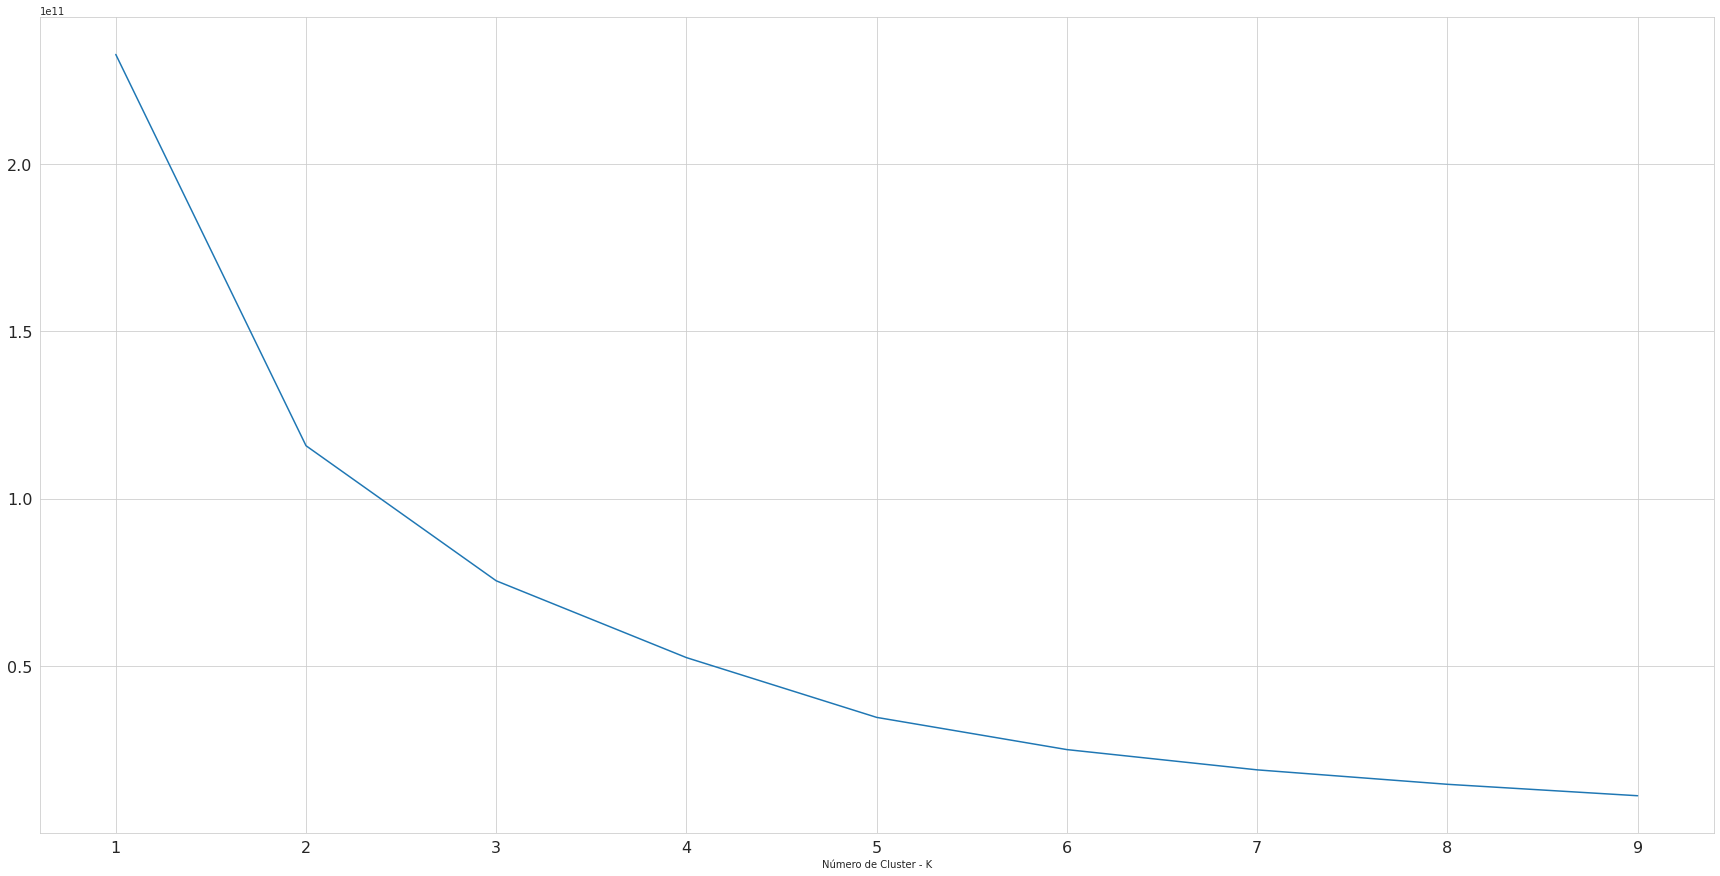

In [52]:
sse={} # Erro

recency_df = users_df[['RECEITA']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency_df)

    # Nome dos clusters relativos ao valor da receita
    recency_df["CLUSTERS"] = kmeans.labels_  

    # Erro correspondente aos clusters
    sse[k] = kmeans.inertia_ 



fig, ax = pyplot.subplots(figsize=(30, 15))

sns.lineplot(x=list(sse.keys()), y=list(sse.values()))

plt.xlabel("Número de Cluster - K")

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.show()

Semelhante aos casos anteriores, K = 4 nos dá um número de clusters ideal. 

In [53]:
# Aplicando a clusterização
kmeans = KMeans(n_clusters=4)

users_df['CLUSTER_RECEITA'] = kmeans.fit_predict(users_df[['RECEITA']])

#Visualizando dados estatísticos dos clusters da receita
users_df.groupby('CLUSTER_RECEITA')['RECEITA'].describe()

,count,mean,std,min,25%,50%,75%,max
CLUSTER_RECEITA,,,,,,,,
0,177642.0,319.149442,276.056000,0.05,98.3425,229.825,474.1400,1109.73
1,5.0,73881.854000,31714.499419,48111.96,50840.3100,53364.330,107129.2200,109963.45
2,29492.0,1897.292060,686.754464,1109.77,1344.6450,1689.415,2278.0750,3931.62
3,3130.0,5957.788061,2592.583681,3933.34,4404.5300,5095.870,6488.2675,33149.90


Para este caso, quanto maior o cluster, maior deve ser a receita total gerada. 

In [54]:
# Ordena os clusters de forma crescente, em que o último cluster terá o maior valor de receita
users_df = order_cluster('CLUSTER_RECEITA', 'RECEITA', users_df, True)


#Visualizando dados estatísticos dos clusters da receita
users_df.groupby('CLUSTER_RECEITA')['RECEITA'].describe()

,count,mean,std,min,25%,50%,75%,max
CLUSTER_RECEITA,,,,,,,,
0,177642.0,319.149442,276.056000,0.05,98.3425,229.825,474.1400,1109.73
1,29492.0,1897.292060,686.754464,1109.77,1344.6450,1689.415,2278.0750,3931.62
2,3130.0,5957.788061,2592.583681,3933.34,4404.5300,5095.870,6488.2675,33149.90
3,5.0,73881.854000,31714.499419,48111.96,50840.3100,53364.330,107129.2200,109963.45


In [55]:
# Visualizando a quantidade de clientes pertencentes a cada cluster
users_df['CLUSTER_RECEITA'].value_counts(ascending=True)

3         5
2      3130
1     29492
0    177642
Name: CLUSTER_RECEITA, dtype: int64

In [56]:
# Definindo um label para cada cluster para visualização
users_df['LABEL_RECEITA'] = 'Alta'

users_df.loc[users_df['CLUSTER_RECEITA'] == 0, 'LABEL_RECEITA'] = 'Muito Baixa' 

users_df.loc[users_df['CLUSTER_RECEITA'] == 1, 'LABEL_RECEITA'] = 'Baixa' 

users_df.loc[users_df['CLUSTER_RECEITA'] == 2,'LABEL_RECEITA'] = 'Média' 

In [57]:
# Visualizando a quantidade de clientes pertencentes a cada cluster
users_df['LABEL_RECEITA'].value_counts(ascending=True)

Alta                5
Média            3130
Baixa           29492
Muito Baixa    177642
Name: LABEL_RECEITA, dtype: int64

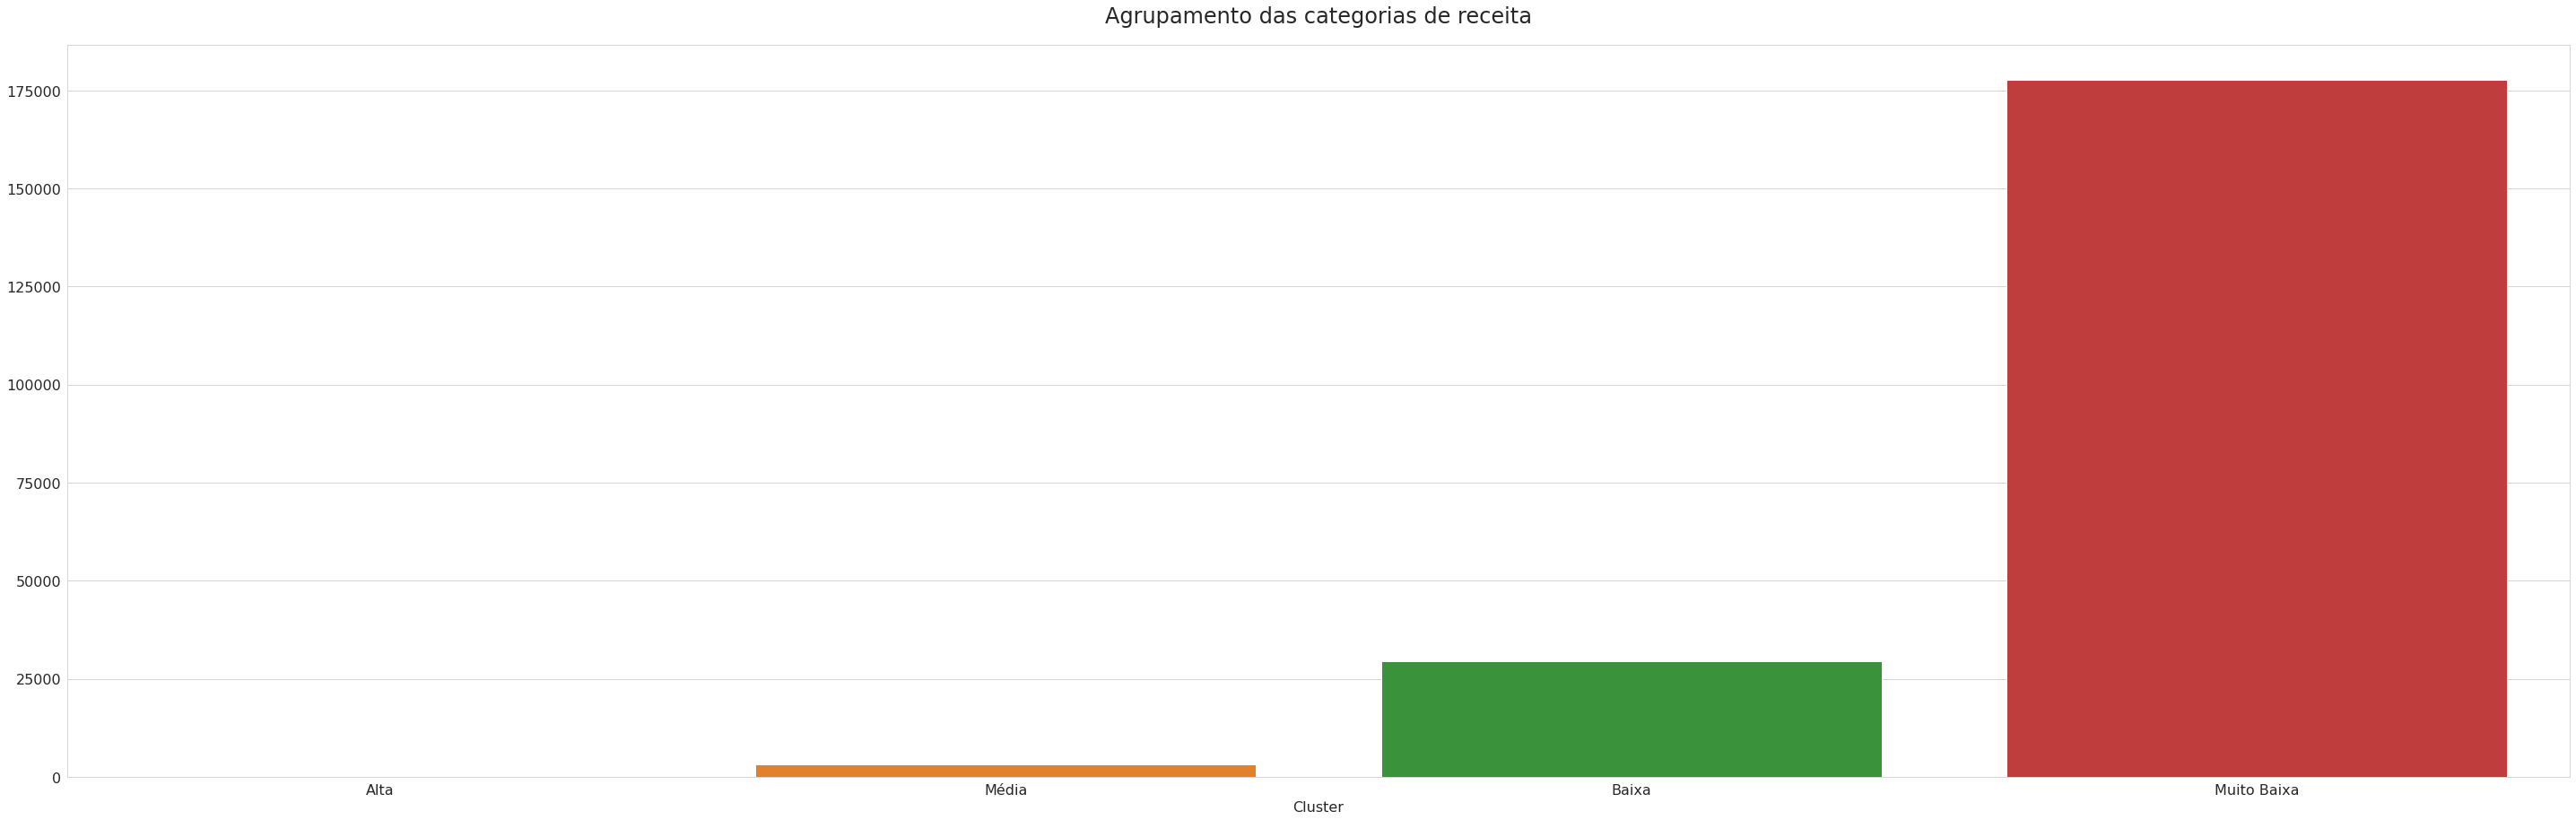

In [58]:
fig, ax = pyplot.subplots(figsize=(50, 15))

sns.barplot(x=users_df['LABEL_RECEITA'].value_counts(ascending=True).index, y=users_df['LABEL_RECEITA'].value_counts(ascending=True))

plt.ylabel("")

plt.xlabel("Cluster", fontsize=16)

plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Agrupamento das categorias de receita", pad=25, fontsize=24)

plt.show()

<a id="section-five"></a>

### 6. Cálculo do RFM

Nós possuímos um Cluster Score para recência, frequência e receita, com isto, iremos criar um score geral que engloba esses três Cluster principais gerando o nosso RFM.

 O RFM é dado pela soma de cada cluster indivualmente.

In [59]:
# Calcula a pontuação geral e use a média para ver os detalhes
users_df['RFM'] = users_df['CLUSTER_RECENCIA'] + users_df['CLUSTER_FREQUENCIA'] + users_df['CLUSTER_RECEITA']

users_df.groupby('RFM')['RECENCIA','FREQUENCIA','RECEITA'].mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,RECENCIA,FREQUENCIA,RECEITA
RFM,,,
0,337.031655,1.628050,130.975935
1,217.734624,2.465189,241.060980
2,105.685012,3.223403,264.518596
3,32.636805,5.376880,396.299930
4,23.976805,12.223242,797.977952
5,18.801121,17.695647,1657.513161
6,12.723917,29.477299,2435.022487
7,9.056043,45.902969,4402.356692
8,5.770682,75.001451,7128.257489




Com isso, podemos perceber que, quanto maior o Score RFM, mais confiável é o consumidor. 

In [60]:
# Visualizando a quantidade de clientes pertencentes a cada cluster
users_df['RFM'].value_counts(ascending=True)

9        3
8      689
7     2391
6     8722
5    16241
1    21430
0    26189
4    29963
2    46405
3    58236
Name: RFM, dtype: int64

In [61]:
users_df['SEGMENTO'] = 'Baixo'
users_df.loc[users_df['RFM'] > 3,'SEGMENTO'] = 'Médio' 
users_df.loc[users_df['RFM'] > 6,'SEGMENTO'] = 'Alto' 

users_df.head()

,ID_CLIENTE,RECENCIA,CLUSTER_RECENCIA,LABEL_RECENCIA,FREQUENCIA,CLUSTER_FREQUENCIA,LABEL_FREQUENCIA,RECEITA,CLUSTER_RECEITA,LABEL_RECEITA,RFM,SEGMENTO
0,337763,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
1,297533,21,3,Alta,11,1,Baixa,998.30,0,Muito Baixa,4,Médio
2,23450,1,3,Alta,10,1,Baixa,648.90,0,Muito Baixa,4,Médio
3,369108,22,3,Alta,12,1,Baixa,160.40,0,Muito Baixa,4,Médio
4,132729,42,3,Alta,20,1,Baixa,883.86,0,Muito Baixa,4,Médio


In [62]:
# Visualizando a quantidade de clientes pertencentes a cada cluster
users_df['SEGMENTO'].value_counts(ascending=True)

Alto       3083
Médio     54926
Baixo    152260
Name: SEGMENTO, dtype: int64

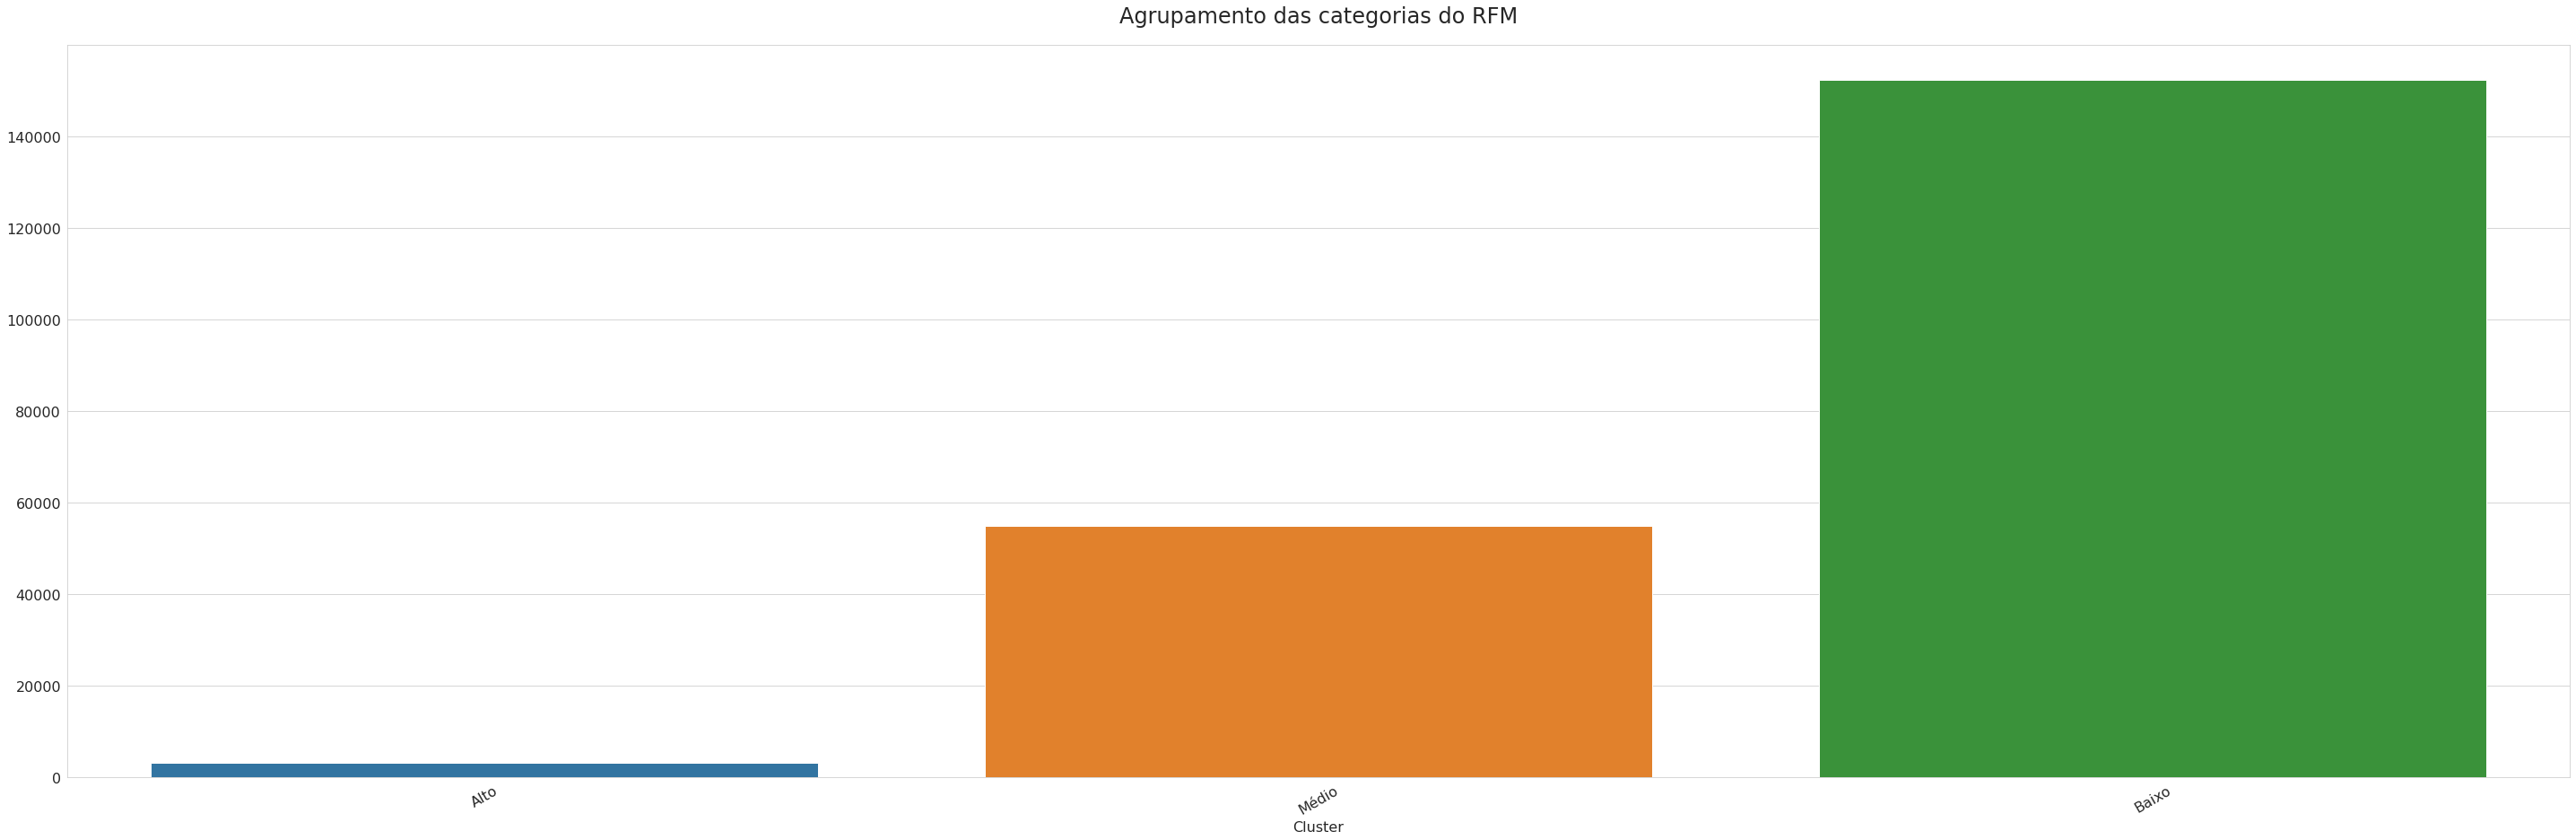

In [63]:
# Visualizando os dados por Segmento
fig, ax = pyplot.subplots(figsize=(50, 15))

sns.barplot(x=users_df['SEGMENTO'].value_counts(ascending=True).index, y=users_df['SEGMENTO'].value_counts(ascending=True))

plt.ylabel("")

plt.xlabel("Cluster", fontsize=16)

plt.xticks(fontsize=16, rotation=30, horizontalalignment='center')

plt.yticks(fontsize=16, rotation=0)

plt.title("Agrupamento das categorias do RFM", pad=25, fontsize=24)

plt.show()

<a id="section-six"></a>

### 7. Cálculo do LTV
Agora entramos na parte que interessa, iremos calcular o valor de LTV de cada cliente durante todo o período do Dataset.



Temos que o LTV é dado pela Receita total - Custo total.

Como no dataset não temos a informação do Custo por cliente, iremos considerar que o Lifetime Value será determinado apenas pela receita total do cliente.

In [64]:
users_df.head()

,ID_CLIENTE,RECENCIA,CLUSTER_RECENCIA,LABEL_RECENCIA,FREQUENCIA,CLUSTER_FREQUENCIA,LABEL_FREQUENCIA,RECEITA,CLUSTER_RECEITA,LABEL_RECEITA,RFM,SEGMENTO
0,337763,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
1,297533,21,3,Alta,11,1,Baixa,998.30,0,Muito Baixa,4,Médio
2,23450,1,3,Alta,10,1,Baixa,648.90,0,Muito Baixa,4,Médio
3,369108,22,3,Alta,12,1,Baixa,160.40,0,Muito Baixa,4,Médio
4,132729,42,3,Alta,20,1,Baixa,883.86,0,Muito Baixa,4,Médio


Agora, iremos analisar a relação entre o RFM e as categorias de Recência, Frequência e Receita. 

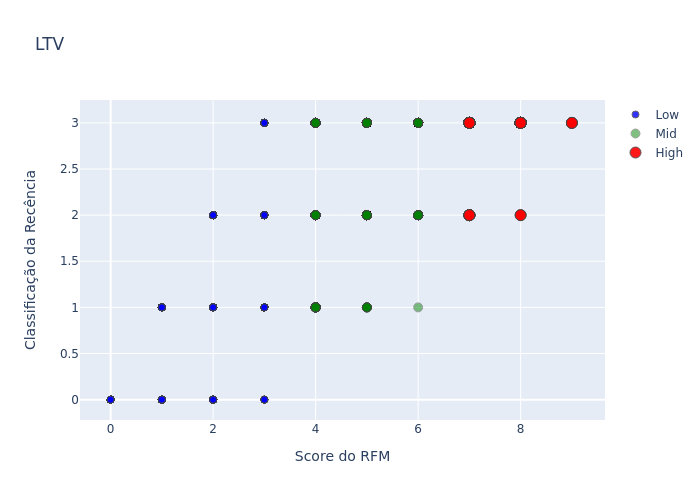

In [65]:
recency_plot_data = [
    go.Scatter(
        x=users_df.query("SEGMENTO == 'Baixo'")['RFM'],
        y=users_df.query("SEGMENTO == 'Baixo'")['CLUSTER_RECENCIA'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=users_df.query("SEGMENTO == 'Médio'")['RFM'],
        y=users_df.query("SEGMENTO == 'Médio'")['CLUSTER_RECENCIA'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=users_df.query("SEGMENTO == 'Alto'")['RFM'],
        y=users_df.query("SEGMENTO == 'Alto'")['CLUSTER_RECENCIA'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Classificação da Recência"},
        xaxis= {'title': "Score do RFM"},
        title='LTV'
    )
fig = go.Figure(data=recency_plot_data, layout=plot_layout)
fig.show(renderer='png')

Para o cluster de Recência temos que clientes no perfil de Baixo RFM tendem a estar em todos os 4 níveis de Recência. Já para os clientes com perfis de Médio RFM tendem a estar nos níveis 1 a 3 de Recênica. Por outro lado, os clientes com Alto perfil de RFM tendem a estar nos níveis 2 a 3 de Recência.

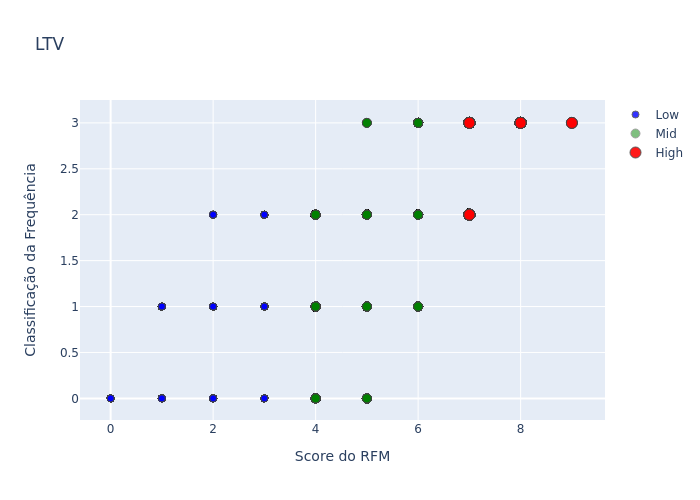

In [66]:
frequency_plot_data = [
    go.Scatter(
        x=users_df.query("SEGMENTO == 'Baixo'")['RFM'],
        y=users_df.query("SEGMENTO == 'Baixo'")['CLUSTER_FREQUENCIA'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=users_df.query("SEGMENTO == 'Médio'")['RFM'],
        y=users_df.query("SEGMENTO == 'Médio'")['CLUSTER_FREQUENCIA'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=users_df.query("SEGMENTO == 'Alto'")['RFM'],
        y=users_df.query("SEGMENTO == 'Alto'")['CLUSTER_FREQUENCIA'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Classificação da Frequência"},
        xaxis= {'title': "Score do RFM"},
        title='LTV'
    )
fig = go.Figure(data=frequency_plot_data, layout=plot_layout)
fig.show(renderer="png")

Para o cluster de Frequência temos que clientes no perfil de Baixo RFM tendem a estar em todos os 3 primeiros níveis de Frequência. Já para os clientes com perfis de Médio RFM tendem a estar em todos os níveis de Frequência. Por outro lado, os clientes com Alto perfil de RFM tendem a estar nos níveis 2 a 3 de Frequência.

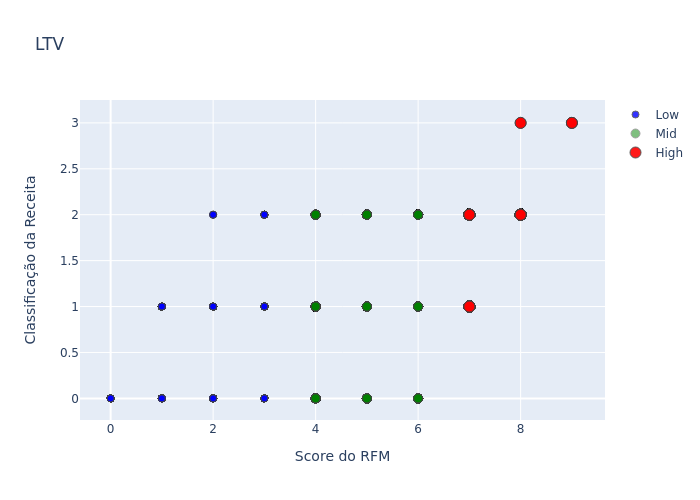

In [67]:
revenue_plot_data = [
    go.Scatter(
        x=users_df.query("SEGMENTO == 'Baixo'")['RFM'],
        y=users_df.query("SEGMENTO == 'Baixo'")['CLUSTER_RECEITA'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=users_df.query("SEGMENTO == 'Médio'")['RFM'],
        y=users_df.query("SEGMENTO == 'Médio'")['CLUSTER_RECEITA'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=users_df.query("SEGMENTO == 'Alto'")['RFM'],
        y=users_df.query("SEGMENTO == 'Alto'")['CLUSTER_RECEITA'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Classificação da Receita"},
        xaxis= {'title': "Score do RFM"},
        title='LTV'
    )
fig = go.Figure(data=revenue_plot_data, layout=plot_layout)
fig.show(renderer="png")

Para o cluster de Receita temos que clientes no perfil de Baixo RFM tendem a estar no nível 0 a 2 de Receita. Já para os clientes com perfis de Médio RFM tendem a estar em todos níveis de Receita. Enquanto isso, os clientes com Alto perfil de RFM tendem a estar nos níveis 2 a 3 de Receita.

<a id="section-seven"></a>

### 8. Determinando features

Para que possamos prever com precisão o LTV de cada cliente nos próximos 3 meses do Dataset iremos utilizar do método de série temporal com a granularidade de mês em mês.

In [68]:
# Seleção das features
featured_df = users_df[['ID_CLIENTE', 'RECENCIA', 'CLUSTER_RECENCIA', 'FREQUENCIA', 'CLUSTER_FREQUENCIA', 'RECEITA', 'CLUSTER_RECEITA', 'RFM']]

featured_df.head()

,ID_CLIENTE,RECENCIA,CLUSTER_RECENCIA,FREQUENCIA,CLUSTER_FREQUENCIA,RECEITA,CLUSTER_RECEITA,RFM
0,337763,1,3,10,1,169.41,0,4
1,297533,21,3,11,1,998.30,0,4
2,23450,1,3,10,1,648.90,0,4
3,369108,22,3,12,1,160.40,0,4
4,132729,42,3,20,1,883.86,0,4


In [69]:
# Criando um dataframe com a coluna ANO_MES_VENDA para ser usado como série temporal mensal
df_month = df

df_month['ANO_MES_VENDA'] = df_month['DT_VENDA'].map(lambda date: 100*date.year + date.month)

df_month.head()

,ID_VENDA,DT_VENDA,LOJA,QTD_SKU,VALOR,ID_CLIENTE,CANAL,ANO_MES_VENDA
0,1176550,2020-01-02,37,1,9.50,337763,FIS,202001
1,11683461,2020-01-02,15,1,6.64,195687,FIS,202001
2,3326484,2020-01-02,29,5,446.87,56059,FIS,202001
3,7317475,2020-01-02,18,1,6.13,297533,FIS,202001
4,4366938,2020-01-02,23,1,13.17,181284,FIS,202001


In [70]:
# Calcula a receita mensal de cada cliente
revenue_per_month = df_month[['ID_CLIENTE', 'VALOR', 'ANO_MES_VENDA']].groupby(['ID_CLIENTE', 'ANO_MES_VENDA']).sum('VALOR')

revenue_per_month.head()

VALOR
ID_CLIENTE ANO_MES_VENDA        
0          202009         266.94
           202012         369.35
2          202001         121.08
           202004         200.68
           202006         104.69

In [71]:
# Cria um dataframe com a receita mensal de cada cliente
revenue_per_month_df = revenue_per_month.reset_index()[['ID_CLIENTE', 'ANO_MES_VENDA', 'VALOR']]

revenue_per_month_df = revenue_per_month_df.rename(columns={"VALOR": "RECEITA"}, errors="raise")

revenue_per_month_df.head()

,ID_CLIENTE,ANO_MES_VENDA,RECEITA
0,0,202009,266.94
1,0,202012,369.35
2,2,202001,121.08
3,2,202004,200.68
4,2,202006,104.69


In [72]:
# Cria um dataframe com todo o período de ano/mês
unique_dates_df = pd.DataFrame(df_month['ANO_MES_VENDA'].unique(), columns=['ANO_MES_VENDA'])

display(unique_dates_df)

,ANO_MES_VENDA
0,202001
1,202002
2,202003
3,202004
4,202005
5,202006
6,202007
7,202008
8,202009
9,202010


In [73]:
# Cria um dataframe com todos os clientes únicos
unique_users = pd.DataFrame(df['ID_CLIENTE'].unique(), columns=['ID_CLIENTE'])

unique_users.head()

,ID_CLIENTE
0,337763
1,195687
2,56059
3,297533
4,181284


In [74]:
# Cria um dataframe auxiliar que irá armazenar para todos os clientes todos os anos/meses
unique_date_client_revenue_df = pd.DataFrame()

for index, row in unique_users.iterrows():
    new_row = unique_dates_df
    new_row['ID_CLIENTE'] = row['ID_CLIENTE']

    unique_date_client_revenue_df = unique_date_client_revenue_df.append(new_row)


In [75]:
# Realização de um left join do Dataframe ano/mes únicos com o Dataframe de receita mensal por cliente a fim de ter para cada uma receita relacionada
result = unique_date_client_revenue_df.merge(revenue_per_month_df, how='left', on=['ID_CLIENTE', 'ANO_MES_VENDA']).fillna(0)

result.columns = ['ANO_MES_VENDA', 'ID_CLIENTE', 'VALOR']

result.head()

,ANO_MES_VENDA,ID_CLIENTE,VALOR
0,202001,337763,51.36
1,202002,337763,89.23
2,202003,337763,10.00
3,202004,337763,0.00
4,202005,337763,0.00


In [76]:
# Realiza o merge com o Dataframe de usuários únicos que contém todas as features para cada cliente
result_merged = result.merge(users_df, how='inner', on=['ID_CLIENTE'])

result_merged.head()

,ANO_MES_VENDA,ID_CLIENTE,VALOR,RECENCIA,CLUSTER_RECENCIA,LABEL_RECENCIA,FREQUENCIA,CLUSTER_FREQUENCIA,LABEL_FREQUENCIA,RECEITA,CLUSTER_RECEITA,LABEL_RECEITA,RFM,SEGMENTO
0,202001,337763,51.36,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
1,202002,337763,89.23,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
2,202003,337763,10.00,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
3,202004,337763,0.00,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
4,202005,337763,0.00,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio


In [77]:
# Iremos utilizar os 3 últimos meses como o modelo de predição da saída dos dias 24/02/2021 até 25/05/2021
predict_df = result_merged[(result_merged['ANO_MES_VENDA'] >= 202012)]

# Com os dados anteriores ao período de predição iremos utilizar para realizar o treinamento
train_test_df = result_merged[(result_merged['ANO_MES_VENDA'] < 202012)]

In [78]:
# Visualização dos dados de predição
predict_df.head()

,ANO_MES_VENDA,ID_CLIENTE,VALOR,RECENCIA,CLUSTER_RECENCIA,LABEL_RECENCIA,FREQUENCIA,CLUSTER_FREQUENCIA,LABEL_FREQUENCIA,RECEITA,CLUSTER_RECEITA,LABEL_RECEITA,RFM,SEGMENTO
11,202012,337763,4.46,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
12,202101,337763,0.00,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
13,202102,337763,14.36,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
25,202012,195687,132.02,75,2,Média,22,2,Média,1241.90,1,Baixa,5,Médio
26,202101,195687,0.00,75,2,Média,22,2,Média,1241.90,1,Baixa,5,Médio


In [79]:
# Visualização dos dados de treinamento
train_test_df.head()

,ANO_MES_VENDA,ID_CLIENTE,VALOR,RECENCIA,CLUSTER_RECENCIA,LABEL_RECENCIA,FREQUENCIA,CLUSTER_FREQUENCIA,LABEL_FREQUENCIA,RECEITA,CLUSTER_RECEITA,LABEL_RECEITA,RFM,SEGMENTO
0,202001,337763,51.36,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
1,202002,337763,89.23,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
2,202003,337763,10.00,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
3,202004,337763,0.00,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
4,202005,337763,0.00,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio


<a id="section-eight"></a>

### 9. Criação do modelo

In [80]:
# Usando Skicit-learn para splitar o dado em set de treinamento e teste
from sklearn.model_selection import train_test_split

# Seleção das features
features = ['ID_CLIENTE', 'ANO_MES_VENDA', 'RECENCIA', 'CLUSTER_RECENCIA', 'FREQUENCIA',	'CLUSTER_FREQUENCIA',	'RECEITA',	'CLUSTER_RECEITA',	'RFM']

X_train, X_test, y_train, y_test = train_test_split(train_test_df[features], train_test_df['VALOR'], test_size=0.33, random_state=42)


In [81]:
# Importação do modelo
from sklearn.ensemble import RandomForestRegressor

# Inicializando o modelo com 100 estimators
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Treinando o modelo
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [82]:
from sklearn.metrics import mean_squared_error

# Utilizando o modelo criado para prever a base de testes
predictions = rf.predict(X_test)

print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, predictions)))

Root Mean Squared Error (RMSE): 92.32147053428095


In [83]:
# Para a saída iremos tentar prever os 3 meses mais recentes que temos dos dados
prediction_df = predict_df.drop(['VALOR'], axis=1)

prediction_df.head()

,ANO_MES_VENDA,ID_CLIENTE,RECENCIA,CLUSTER_RECENCIA,LABEL_RECENCIA,FREQUENCIA,CLUSTER_FREQUENCIA,LABEL_FREQUENCIA,RECEITA,CLUSTER_RECEITA,LABEL_RECEITA,RFM,SEGMENTO
11,202012,337763,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
12,202101,337763,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
13,202102,337763,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio
25,202012,195687,75,2,Média,22,2,Média,1241.90,1,Baixa,5,Médio
26,202101,195687,75,2,Média,22,2,Média,1241.90,1,Baixa,5,Médio


In [84]:
prediction_df['VALOR'] = rf.predict(prediction_df[features])

prediction_df.head()

,ANO_MES_VENDA,ID_CLIENTE,RECENCIA,CLUSTER_RECENCIA,LABEL_RECENCIA,FREQUENCIA,CLUSTER_FREQUENCIA,LABEL_FREQUENCIA,RECEITA,CLUSTER_RECEITA,LABEL_RECEITA,RFM,SEGMENTO,VALOR
11,202012,337763,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio,11.2501
12,202101,337763,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio,11.2501
13,202102,337763,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio,11.2501
25,202012,195687,75,2,Média,22,2,Média,1241.90,1,Baixa,5,Médio,72.1931
26,202101,195687,75,2,Média,22,2,Média,1241.90,1,Baixa,5,Médio,72.1931


Está na hora de gerar a saída :)

In [85]:
result_predicted_df = prediction_df.copy()

result_predicted_df.head()

,ANO_MES_VENDA,ID_CLIENTE,RECENCIA,CLUSTER_RECENCIA,LABEL_RECENCIA,FREQUENCIA,CLUSTER_FREQUENCIA,LABEL_FREQUENCIA,RECEITA,CLUSTER_RECEITA,LABEL_RECEITA,RFM,SEGMENTO,VALOR
11,202012,337763,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio,11.2501
12,202101,337763,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio,11.2501
13,202102,337763,1,3,Alta,10,1,Baixa,169.41,0,Muito Baixa,4,Médio,11.2501
25,202012,195687,75,2,Média,22,2,Média,1241.90,1,Baixa,5,Médio,72.1931
26,202101,195687,75,2,Média,22,2,Média,1241.90,1,Baixa,5,Médio,72.1931


In [86]:
trated_result_predicted_df = result_predicted_df.copy()

trated_result_predicted_df.loc[(trated_result_predicted_df['VALOR'] < 0), 'VALOR'] = 0

In [87]:
result_submission = trated_result_predicted_df.groupby('ID_CLIENTE').sum()['VALOR']

result_submission.head()

ID_CLIENTE
0    286.2135
2    556.1898
3      0.0000
4    805.8858
5      0.0000
Name: VALOR, dtype: float64

In [88]:
result_submission_df = pd.DataFrame(result_submission, columns=['VALOR']).reset_index()


result_submission_df.head()

,ID_CLIENTE,VALOR
0,0,286.2135
1,2,556.1898
2,3,0.0000
3,4,805.8858
4,5,0.0000


In [89]:
sample_submission = pd.read_csv('../input/VLabs-DC/sample_submission.csv')

sample_submission.head()

,ID_CLIENTE,VALOR
0,4,0.0
1,9,0.0
2,12,0.0
3,15,0.0
4,19,0.0


In [90]:
result_submission = sample_submission.merge(result_submission_df, on='ID_CLIENTE', how='left')

result_submission.head()

,ID_CLIENTE,VALOR_x,VALOR_y
0,4,0.0,805.8858
1,9,0.0,70.0650
2,12,0.0,207.6303
3,15,0.0,126.3330
4,19,0.0,0.0000


In [91]:
result_submission.shape

(126616, 3)

In [92]:
result_submission = result_submission[['ID_CLIENTE', 'VALOR_y']]

result_submission.columns = ['ID_CLIENTE', 'VALOR']

result_submission.head()

,ID_CLIENTE,VALOR
0,4,805.8858
1,9,70.0650
2,12,207.6303
3,15,126.3330
4,19,0.0000


In [93]:
result_submission.to_csv('./result.csv', index=False)

Com isto, temos o resultado da predição do LTV próximos 90 dias de cada cliente. 

Próximos passos: 

- Evoluir a análise da série temporal;
- Complementar as features com valores de tendência em cada período de compras;
- Melhorar a predição com vários algorítmos de Regressão estudando os melhores parâmetros;